# The goal here is to benchmark the DpoDetection tool with other depolymerase detection tools 
***
# I. Load the models :
#### 77 phages candidates 
>Detected Dpos <br>
>Missed Dpos <br>
***
# II. Getting the resulting predictions
#### Pires Dpos
***


I.
> Make the predictions : DpoDetection Tool :

In [1]:
from transformers import AutoModelForTokenClassification, AutoTokenizer
import torch
from torch import nn 
import torch.nn.functional as F

import os
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import json
from Bio import SeqIO

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

path_work = "/home/conchae/PhageDepo_pdb"

esm2_model_path = f"{path_work}/script_files/esm2_t30_150M_UR50D-finetuned-depolymerase.0407.3_labels/checkpoint-550"
DpoDetection_path = f"{path_work}/DepoDetection.esm2_t30_150M_UR50D.0407.model"

tokenizer = AutoTokenizer.from_pretrained(esm2_model_path)
esm2_finetuned = AutoModelForTokenClassification.from_pretrained(esm2_model_path)


/home/concha-eloko/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at /media/concha-eloko/Linux/depolymerase_building/esm2_t12_35M_UR50D-finetuned-depolymerase.0407.3_labels/checkpoint-550/ were not used when initializing EsmForTokenClassification: ['esm.contact_head.regression.bias', 'esm.contact_head.regression.weight']
- This IS expected if you are initializing EsmForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a 

In [4]:
class Dpo_classifier(nn.Module):
    def __init__(self, pretrained_model):
        super(Dpo_classifier, self).__init__()
        self.max_length = 1024
        self.pretrained_model = pretrained_model
        self.conv1 = nn.Conv1d(1, 64, kernel_size=5, stride=1)  # Convolutional layer
        self.conv2 = nn.Conv1d(64, 128, kernel_size=5, stride=1)  # Convolutional layer
        self.fc1 = nn.Linear(128 * (self.max_length - 2 * (5 - 1)), 32)  # calculate the output shape after 2 conv layers
        self.classifier = nn.Linear(32, 2)  # Binary classification

    def make_prediction(self, fasta_txt):
        input_ids = tokenizer.encode(fasta_txt, truncation=True, return_tensors='pt')
        with torch.no_grad():
            outputs = self.pretrained_model(input_ids)
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
            token_probs, token_ids = torch.max(probs, dim=-1)            
            tokens = token_ids.view(1, -1) # ensure 2D shape
            return tokens

    def pad_or_truncate(self, tokens):
        if tokens.size(1) < self.max_length:
            tokens = F.pad(tokens, (0, self.max_length - tokens.size(1)))
        elif tokens.size(1) > self.max_length:
            tokens = tokens[:, :self.max_length]
        return tokens

    def forward(self, sequences):
        batch_size = len(sequences)
        tokens_batch = []
        for seq in sequences:
            tokens = self.make_prediction(seq)
            tokens = self.pad_or_truncate(tokens)
            tokens_batch.append(tokens)
        
        outputs = torch.cat(tokens_batch).view(batch_size, 1, self.max_length)  # ensure 3D shape
        outputs = outputs.float()  # Convert to float
        
        out = F.relu(self.conv1(outputs))
        out = F.relu(self.conv2(out))
        out = out.view(batch_size, -1)  # Flatten the tensor
        out = F.relu(self.fc1(out))
        out = self.classifier(out)
        return out, outputs


In [5]:
model_classifier = Dpo_classifier(esm2_finetuned) # Create an instance of Dpo_classifier
model_classifier.load_state_dict(torch.load(DpoDetection_path), strict = False) # Load the saved weights ; weird Error with some of the keys 
model_classifier.eval() # Set the model to evaluation mode for inference


Dpo_classifier(
  (pretrained_model): EsmForTokenClassification(
    (esm): EsmModel(
      (embeddings): EsmEmbeddings(
        (word_embeddings): Embedding(33, 480, padding_idx=1)
        (position_embeddings): Embedding(1026, 480, padding_idx=1)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): EsmEncoder(
        (layer): ModuleList(
          (0): EsmLayer(
            (attention): EsmAttention(
              (self): EsmSelfAttention(
                (query): Linear(in_features=480, out_features=480, bias=True)
                (key): Linear(in_features=480, out_features=480, bias=True)
                (value): Linear(in_features=480, out_features=480, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
                (rotary_embeddings): RotaryEmbedding()
              )
              (output): EsmSelfOutput(
                (dense): Linear(in_features=480, out_features=480, bias=True)
                (dropout): Dropout(p=0.0, inplace=False

In [80]:
def predict_sequence(model, sequence):
    model.eval()  
    with torch.no_grad():   
        outputs, sequence_outputs = model([sequence])
        probas = torch.nn.functional.softmax(outputs, dim=-1)
        predictions = torch.argmax(probas, dim=1)  
        sequence_outputs_list = sequence_outputs.cpu().numpy().tolist()[0][0]  
        prob_predicted = probas[0][predictions].item()
        return (predictions.item(), prob_predicted), sequence_outputs_list


***
### 77 predictions 

(1, 1.0) K10PH82C1_cds_50


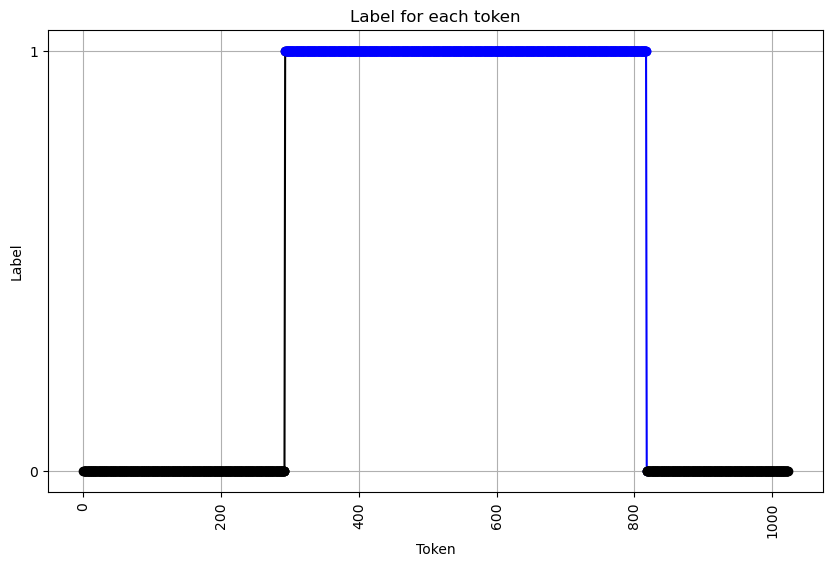

(1, 1.0) K10PH82C1_cds_51


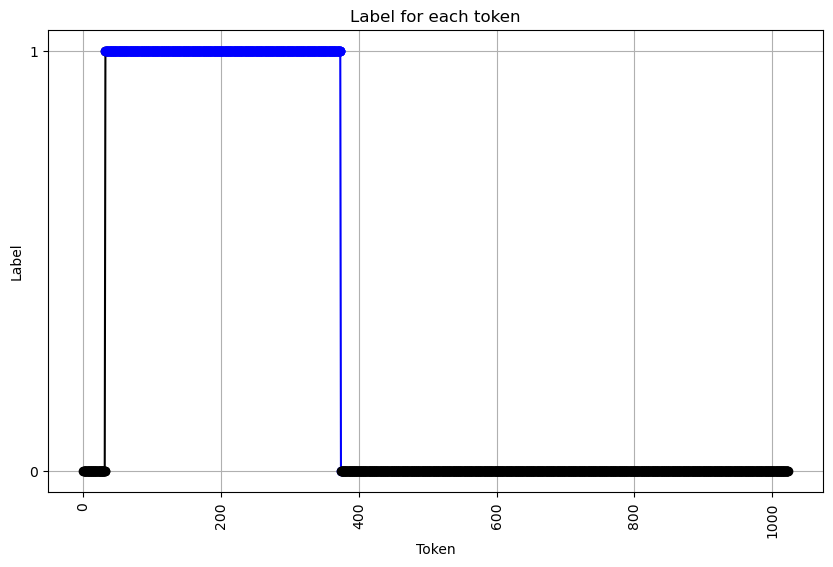

(1, 1.0) K11PH164C1_cds_45


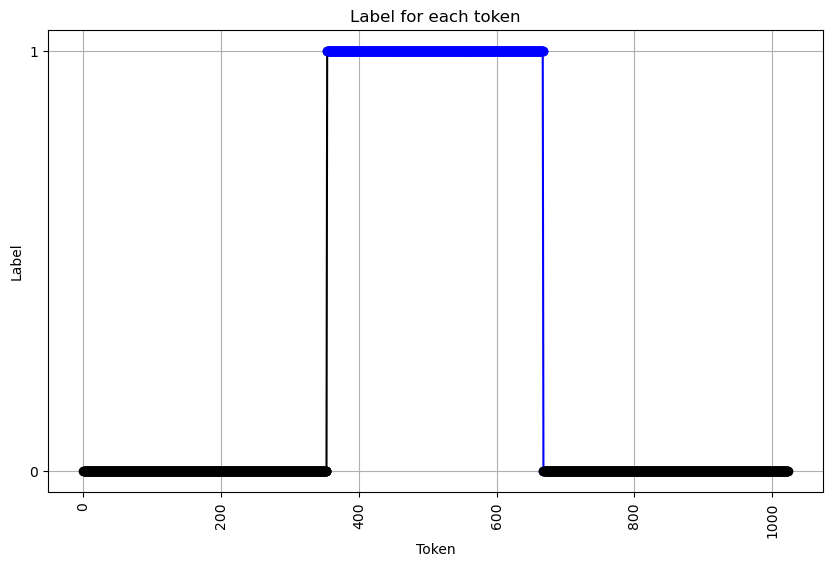

(1, 1.0) K11PH164C1_cds_46


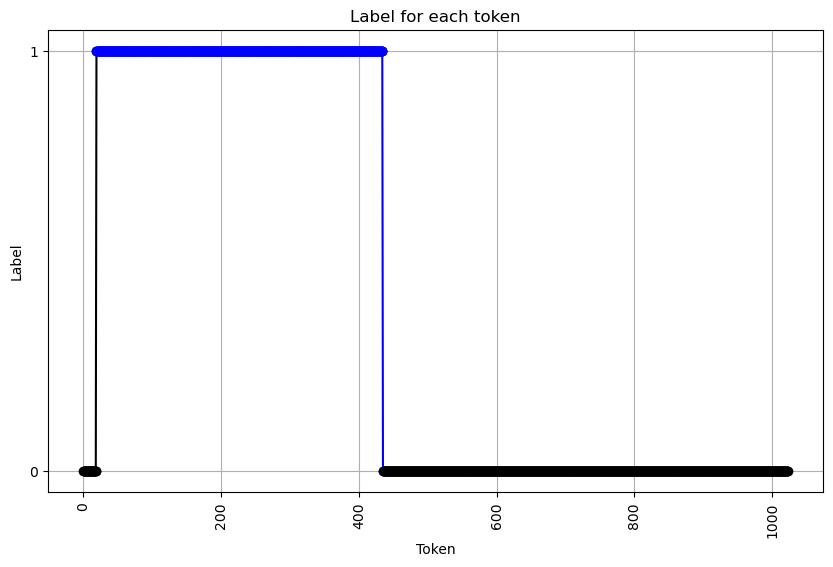

(1, 1.0) K13PH07C1L_cds_10


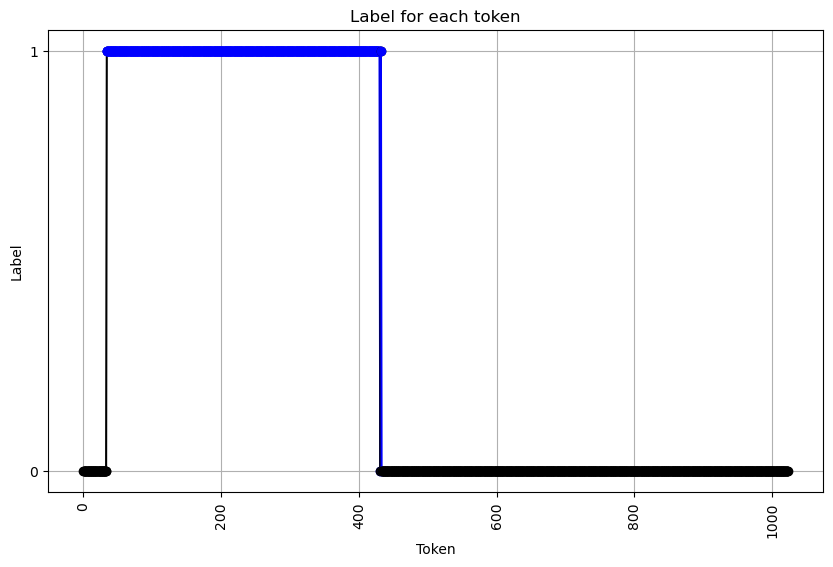

(1, 1.0) K13PH07C1L_cds_11


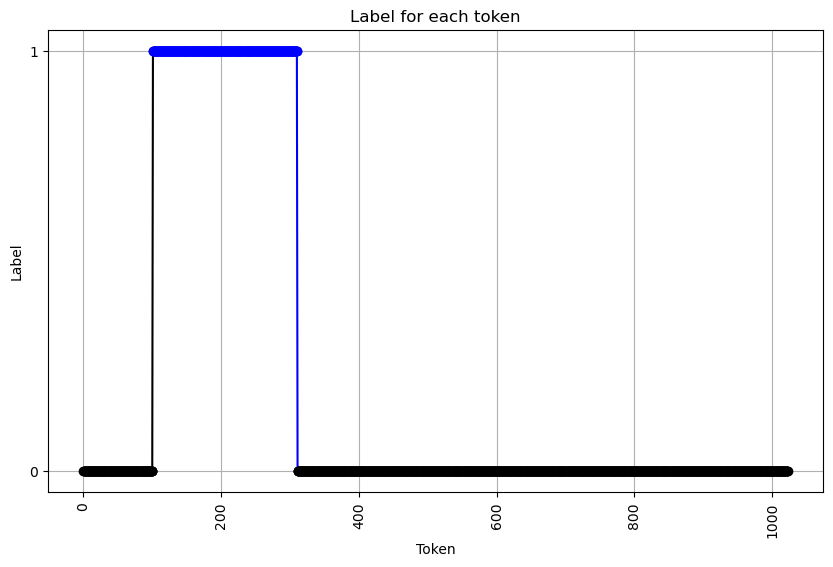

(1, 0.9999498128890991) K13PH07C1L_cds_12


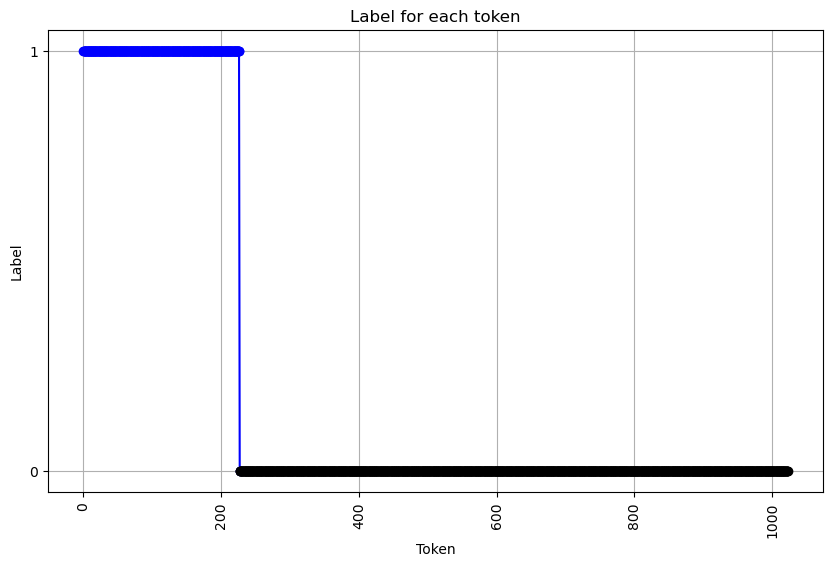

(1, 1.0) K13PH07C1S_cds_10


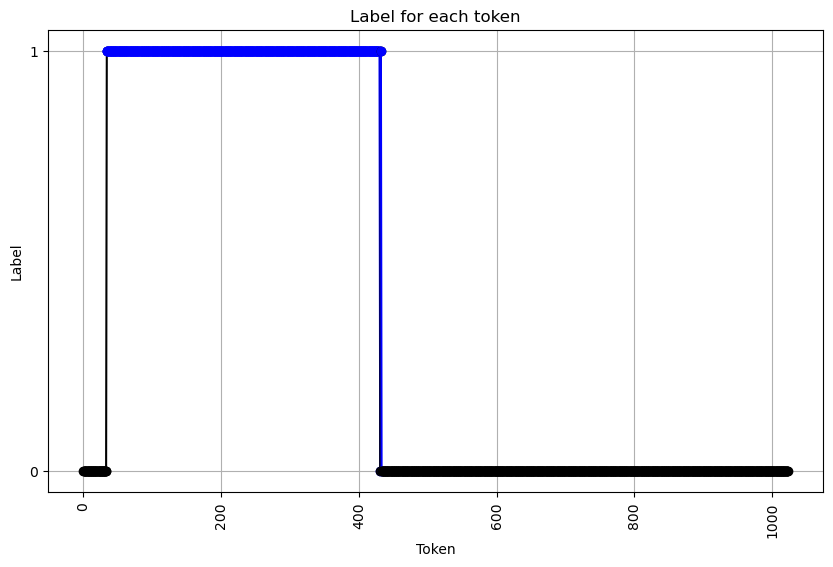

(1, 1.0) K13PH07C1S_cds_11


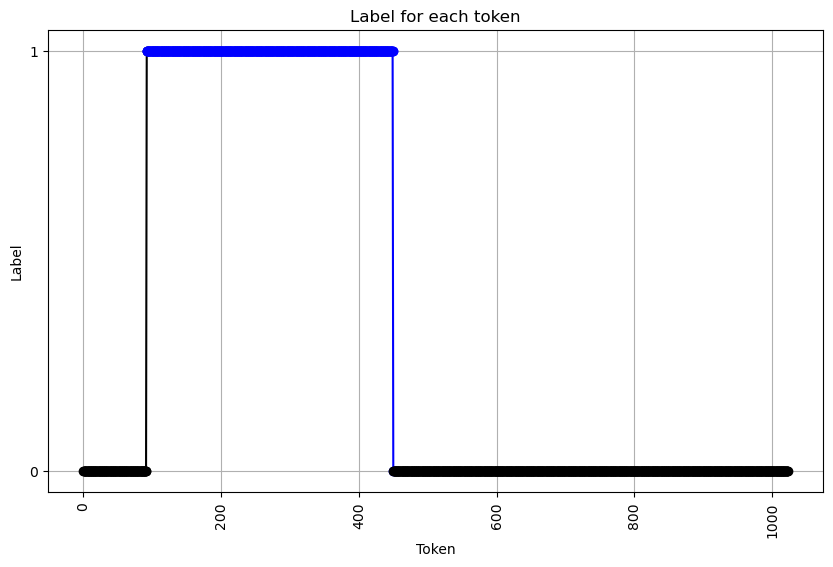

(1, 1.0) K14PH164C1_cds_24


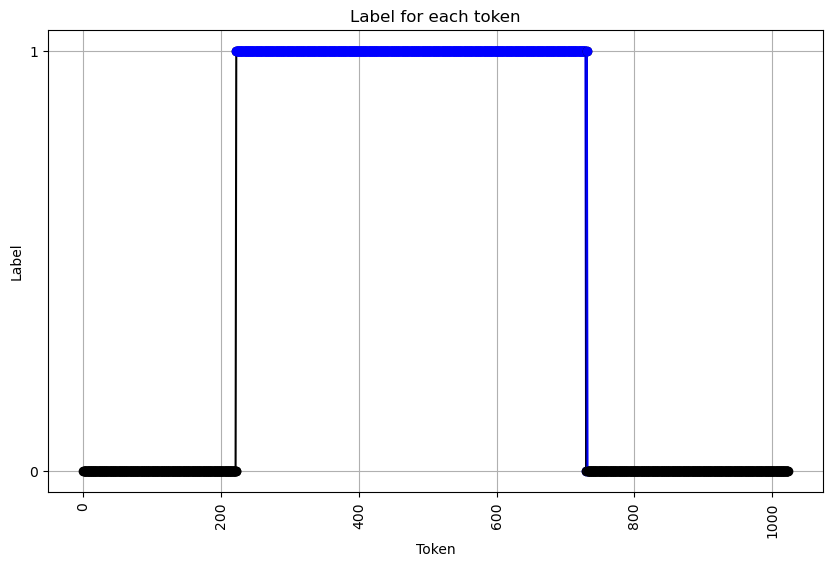

(1, 1.0) K15PH90_cds_55


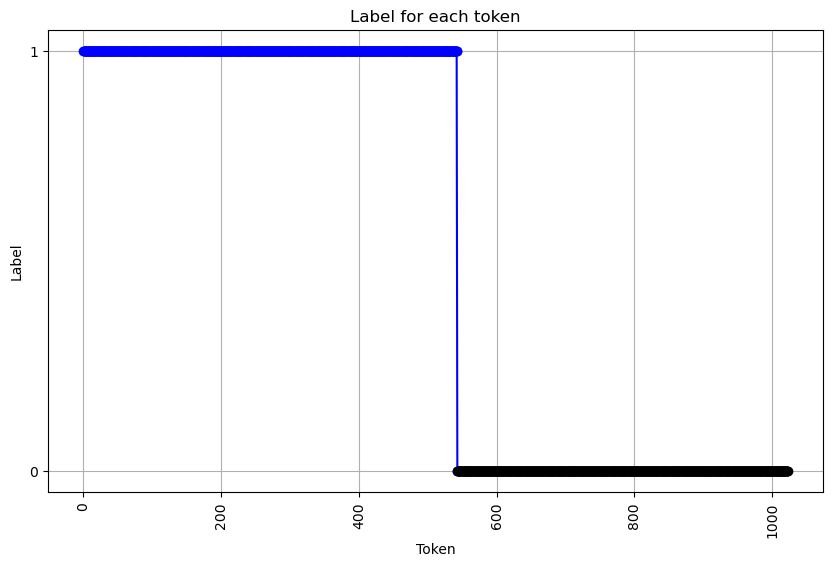

(1, 1.0) K16PH164C3_cds_48


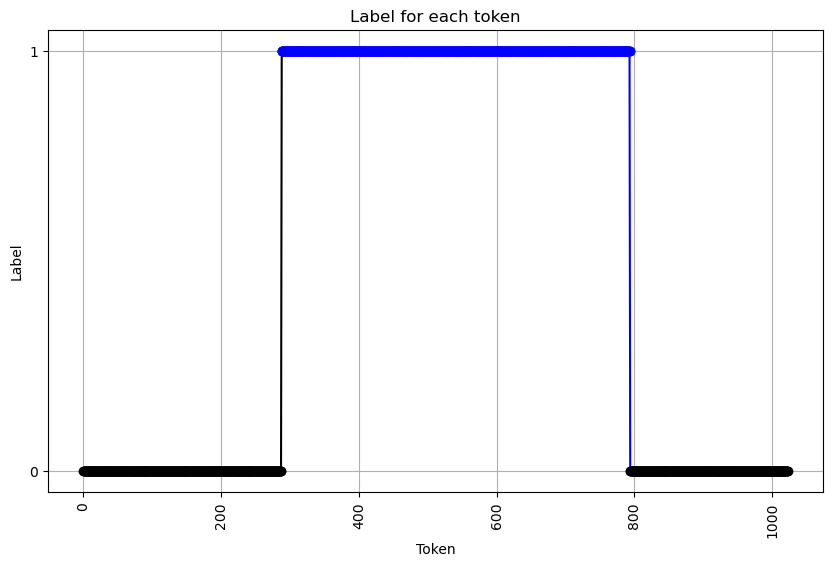

(1, 1.0) K17alfa61_cds_23


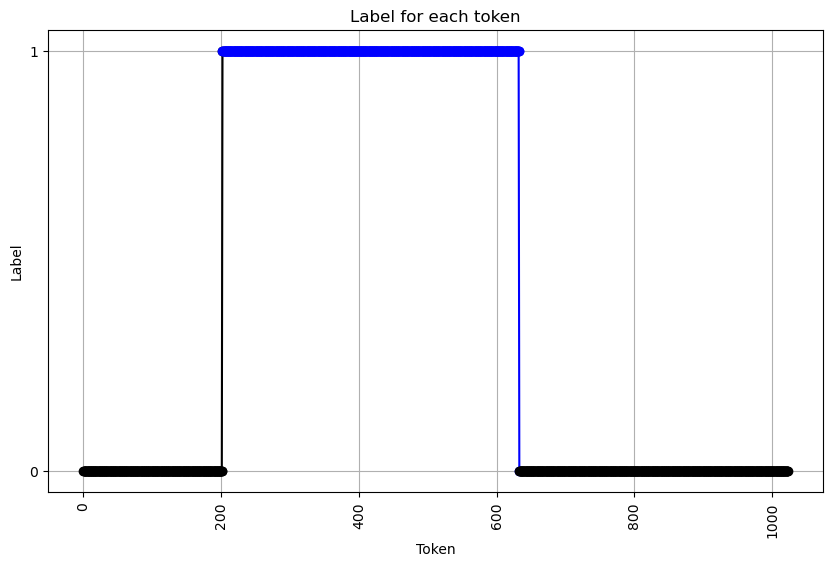

(1, 1.0) K17alfa62_cds_64


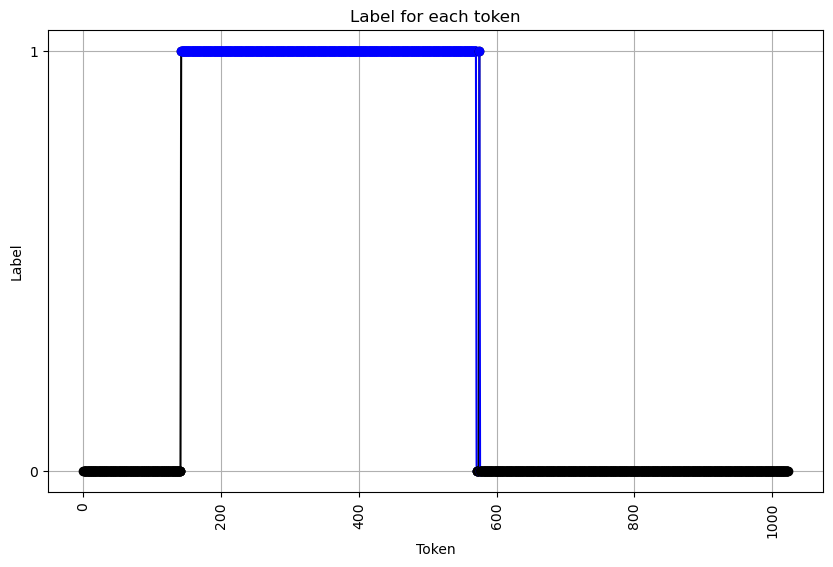

(1, 1.0) K17alfa62_cds_66


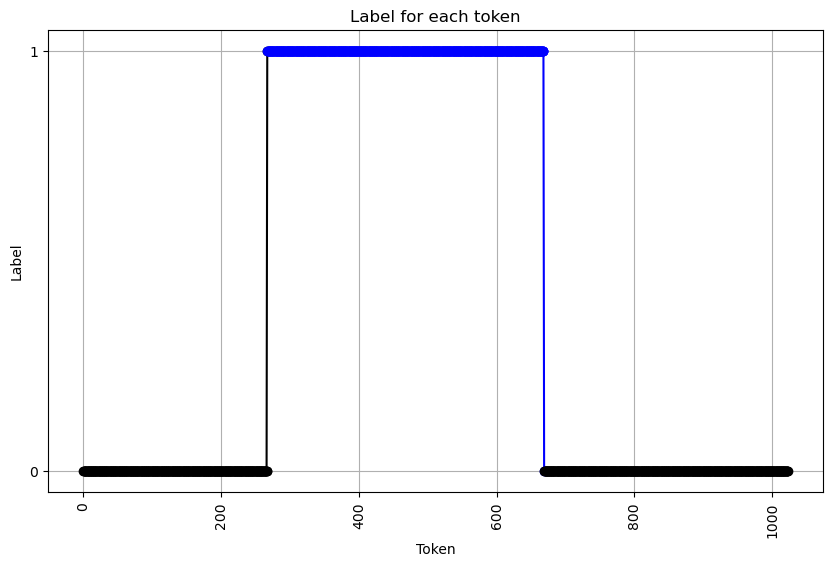

(1, 1.0) K18PH07C1_cds_243


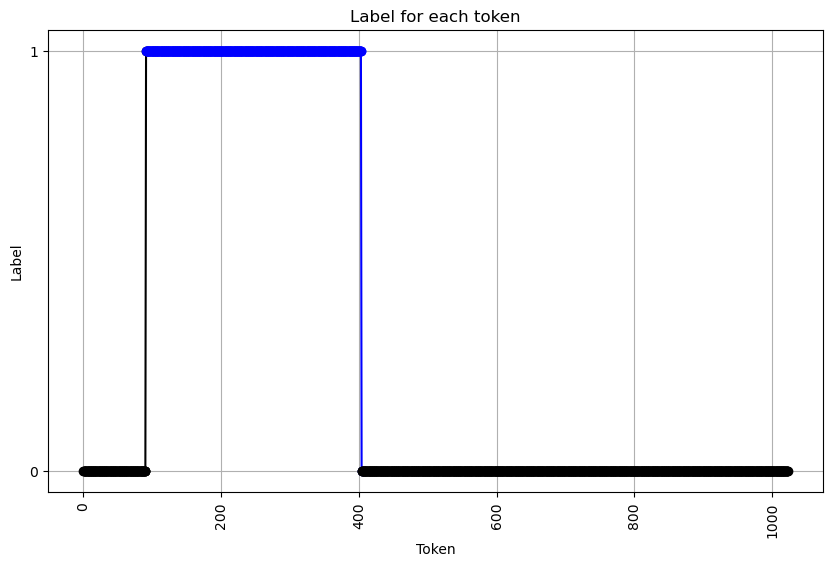

(1, 1.0) K18PH07C1_cds_245


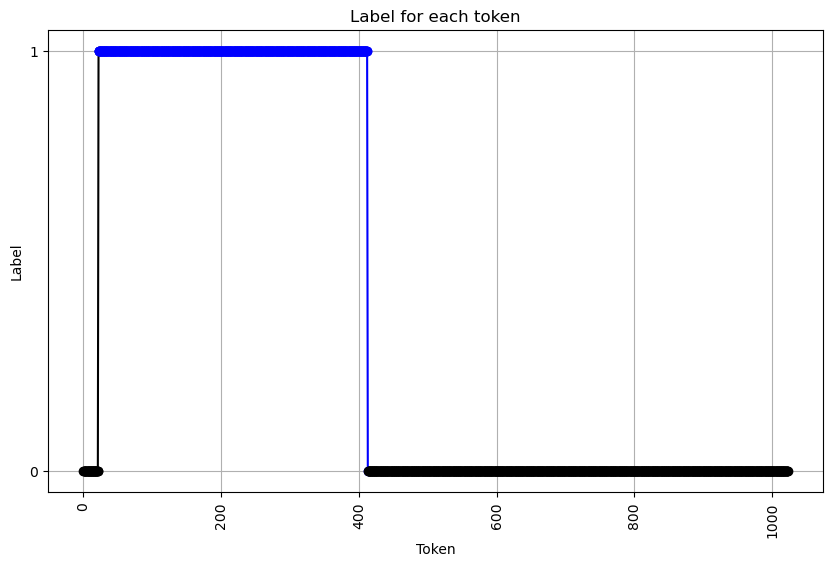

(1, 1.0) K1PH164C1_cds_8


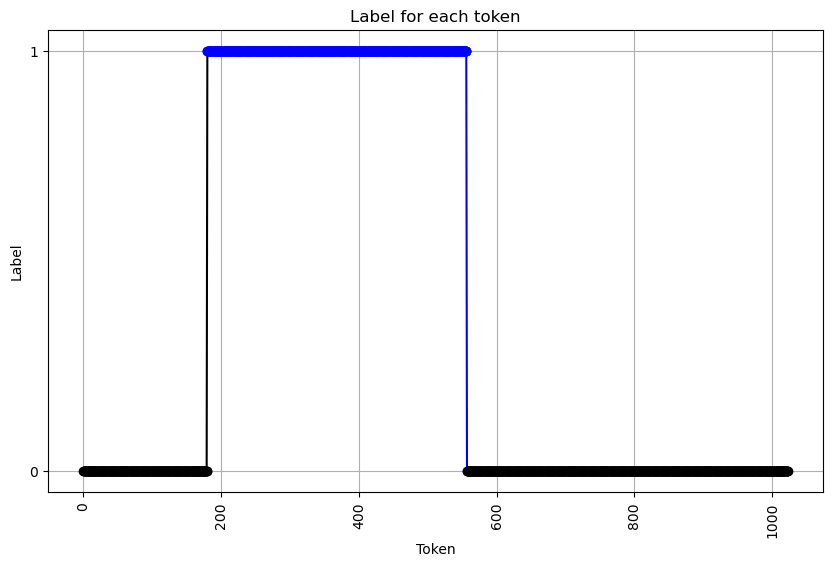

(1, 1.0) K21lambda1_cds_28


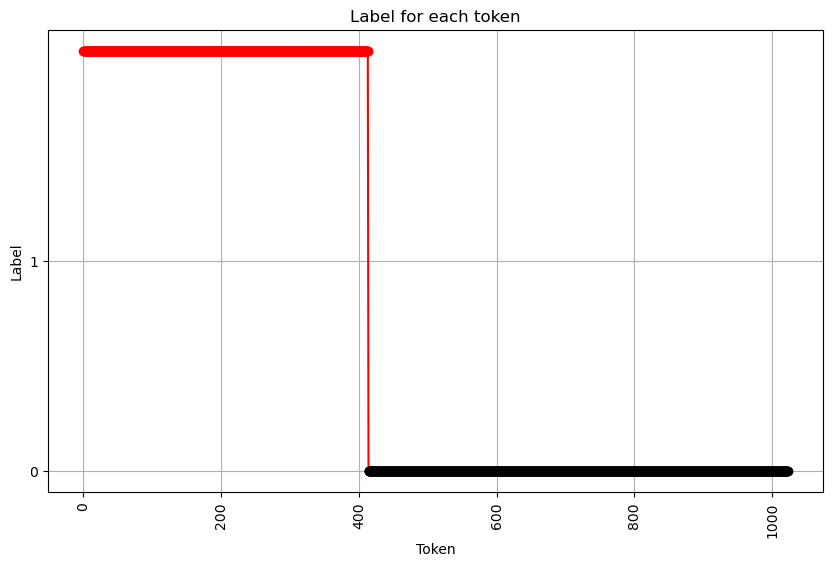

(1, 1.0) K22PH164C1_cds_10


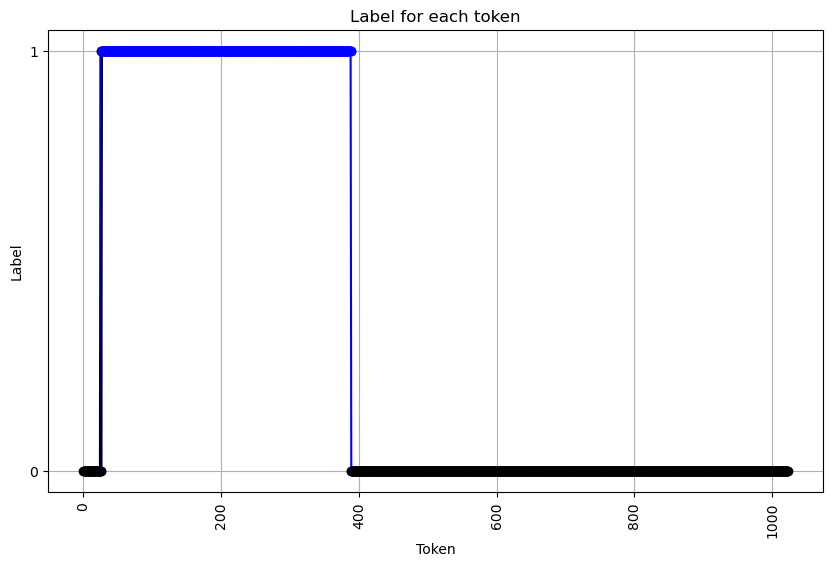

(1, 1.0) K22PH164C1_cds_11


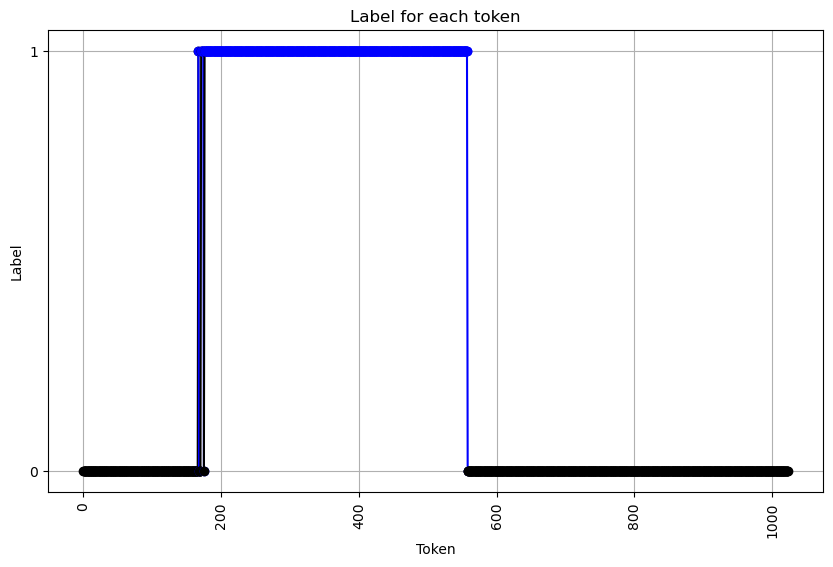

(1, 1.0) K23PH08C2_cds_233


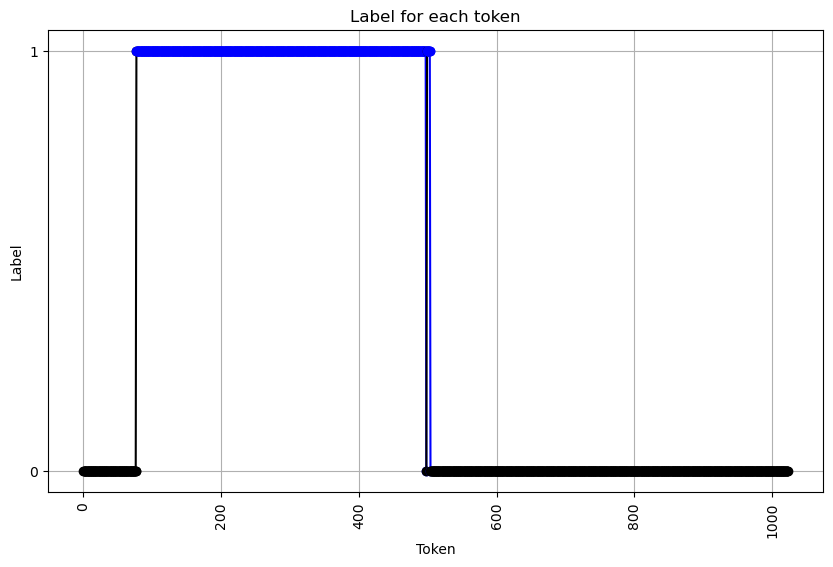

(1, 1.0) K24PH164C1_cds_8


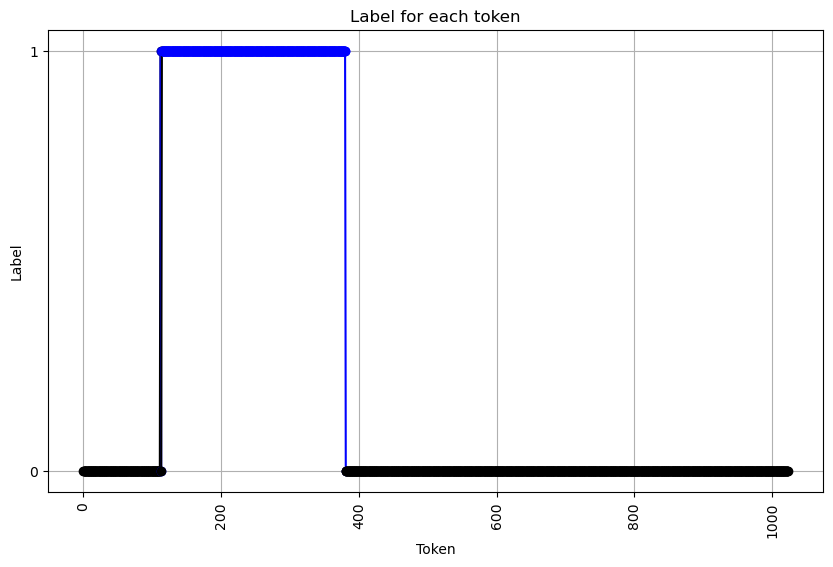

(1, 1.0) K25PH129C1_cds_60


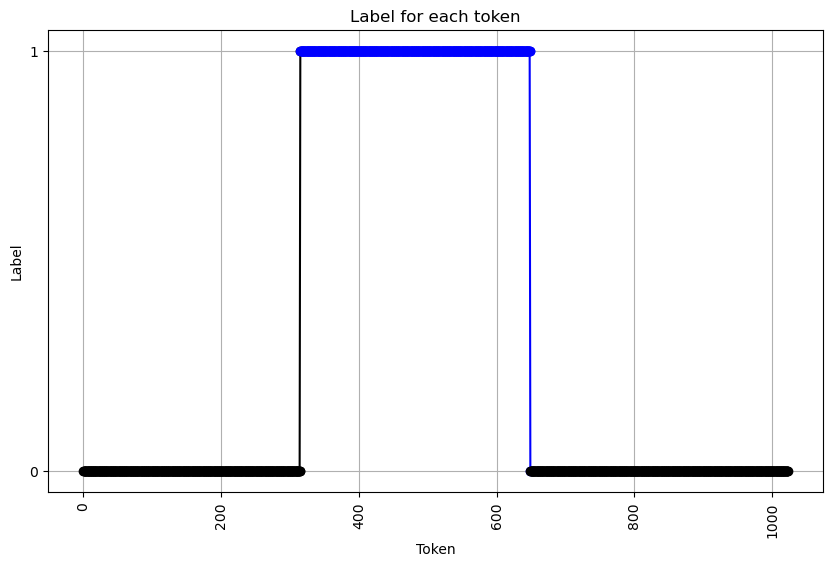

(1, 1.0) K26PH128C1_cds_49


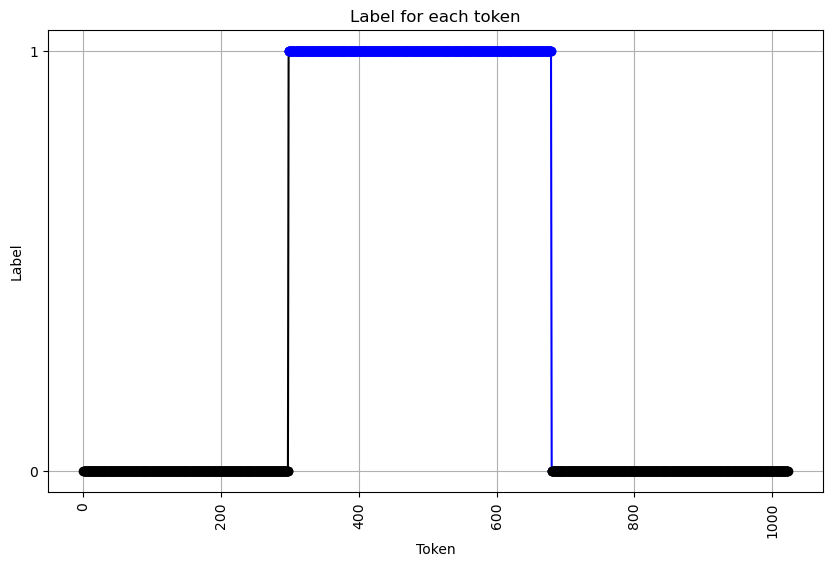

(1, 1.0) K26PH128C1_cds_50


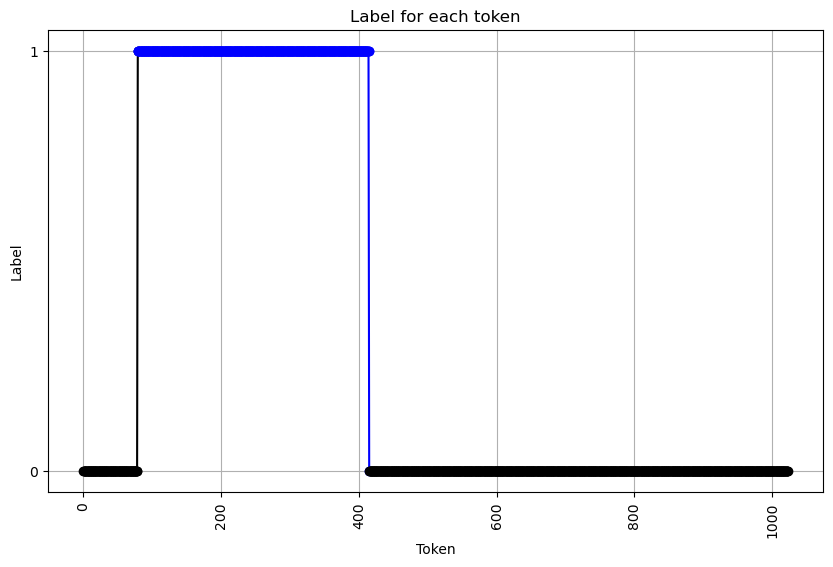

(1, 1.0) K27PH129C1_cds_48


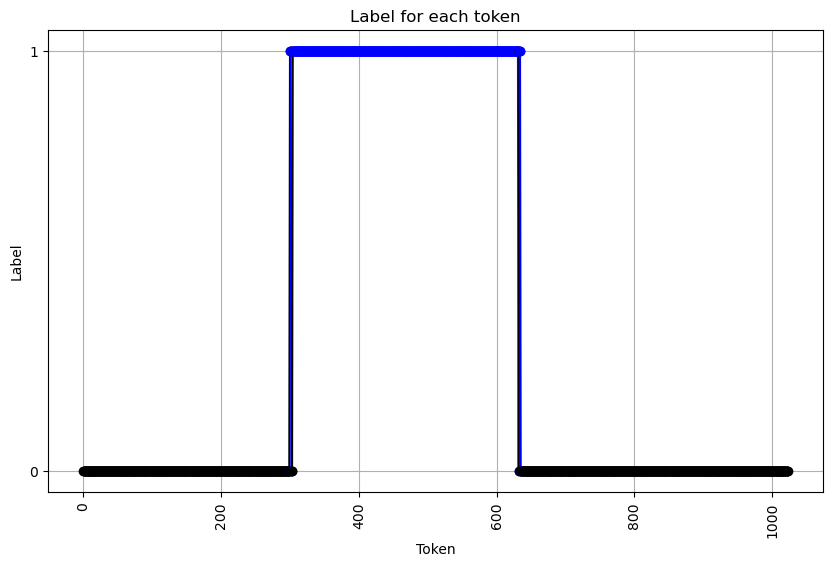

(1, 1.0) K2PH164C1_cds_23


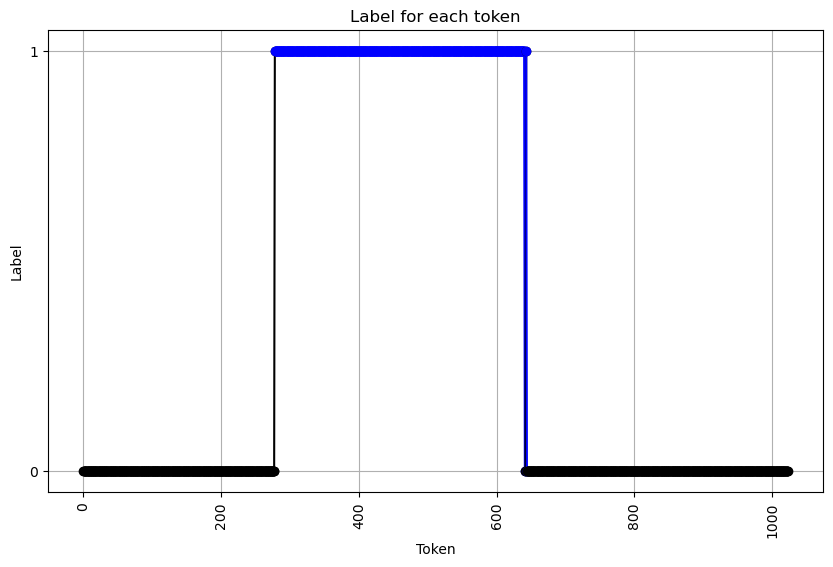

(1, 1.0) K2PH164C2_cds_24


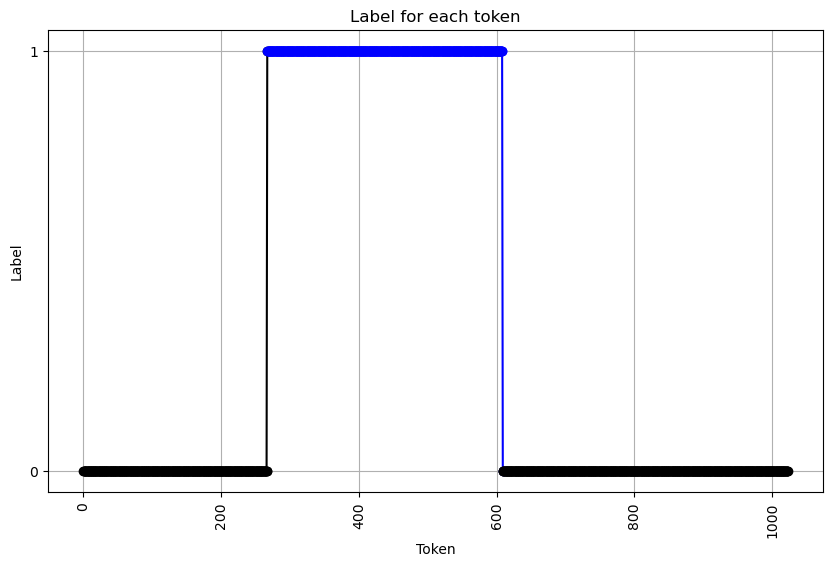

(1, 1.0) K2alfa62_cds_23


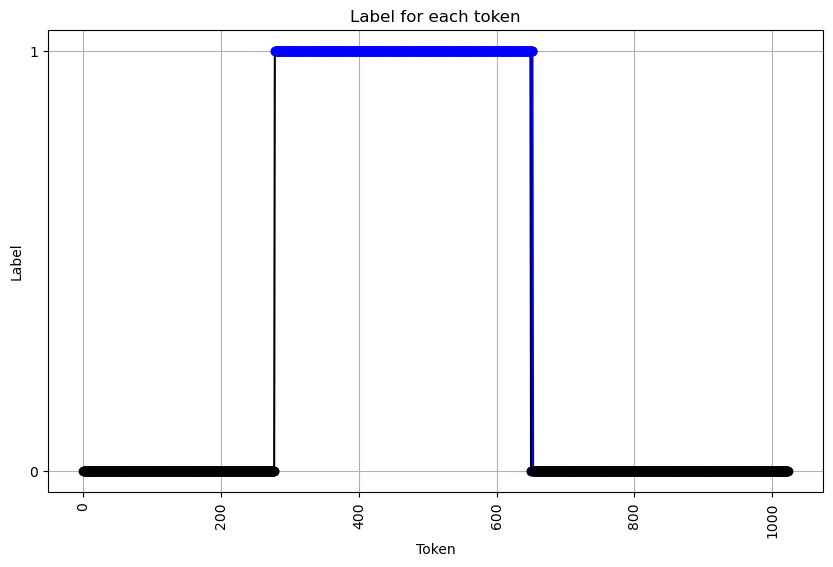

(1, 1.0) K35PH164C3_cds_48


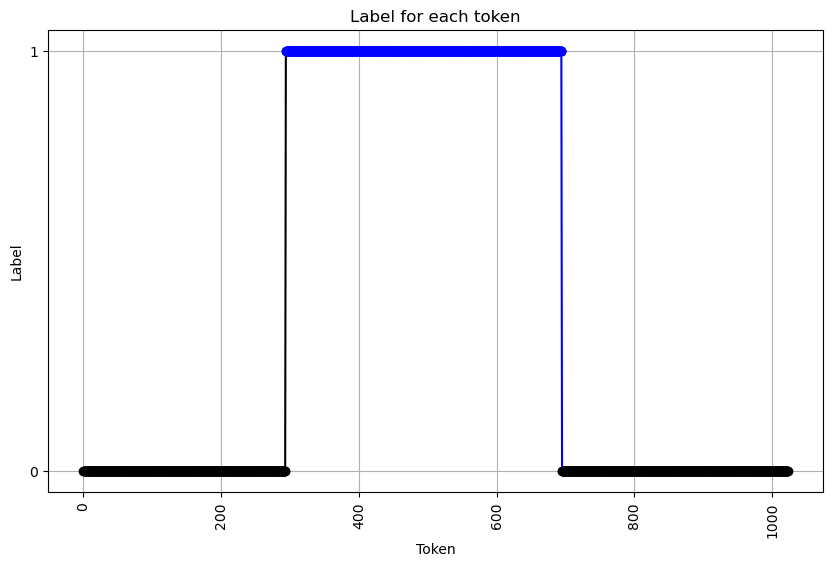

(1, 1.0) K37PH164C1_cds_47


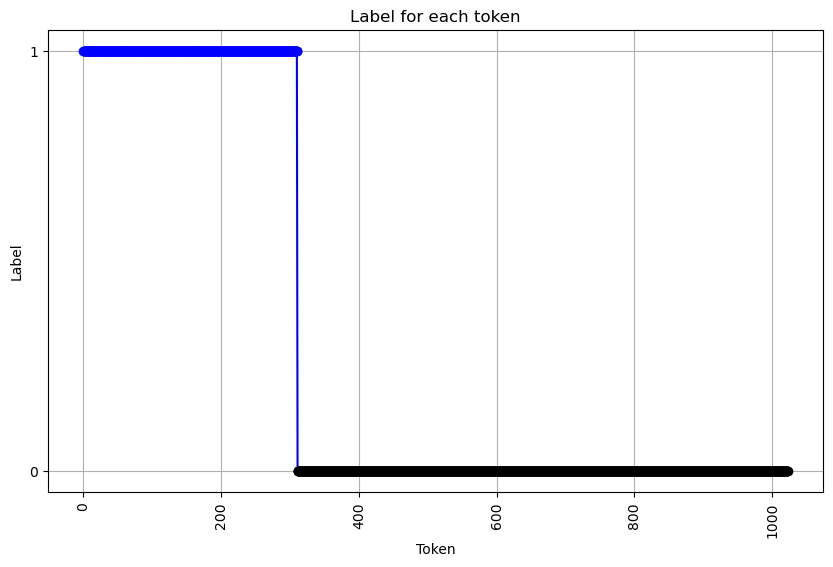

(1, 1.0) K37PH164C1_cds_48


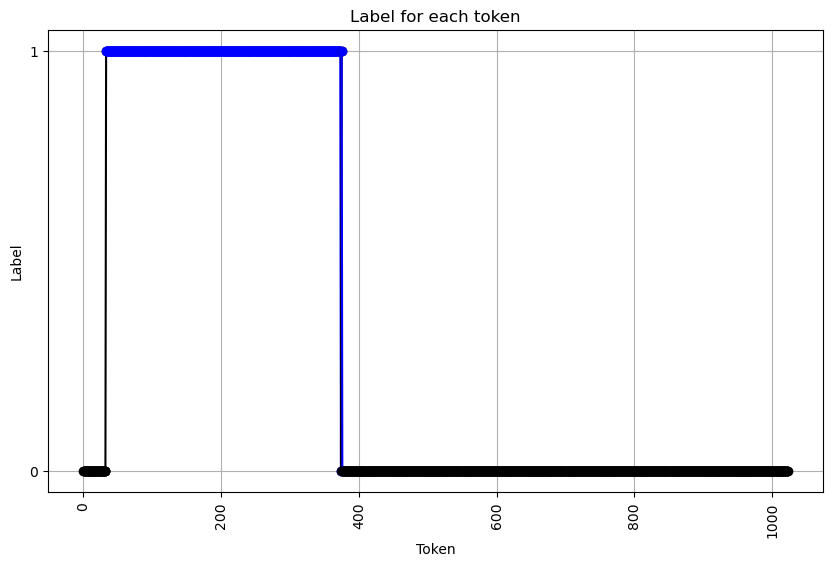

(1, 1.0) K38PH09C2_cds_24


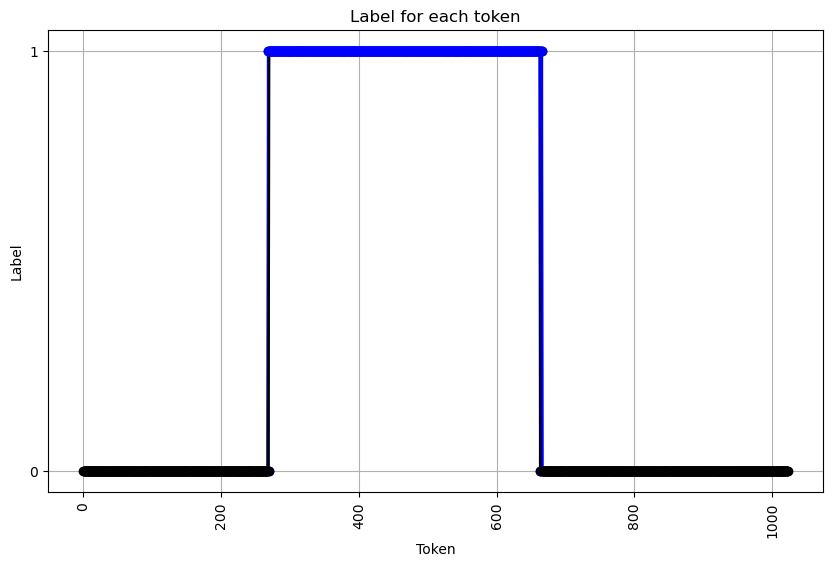

(1, 1.0) K39PH122C2_cds_8


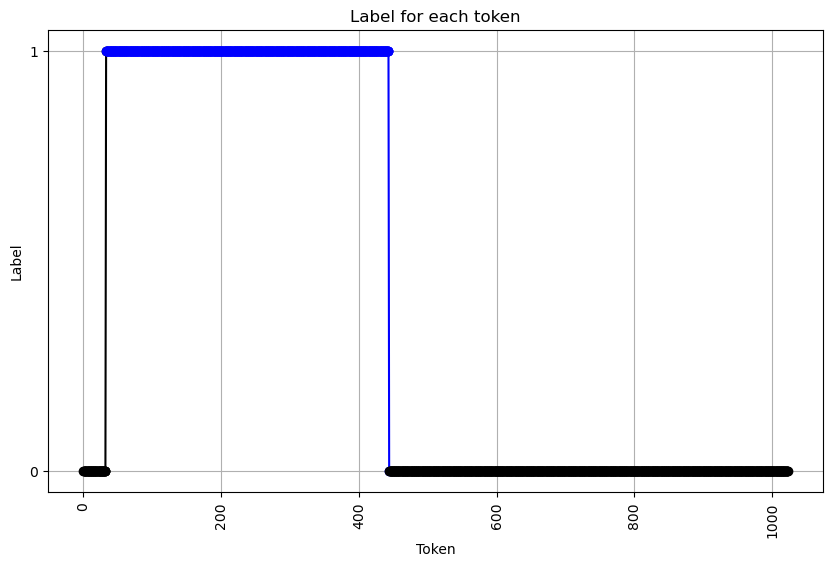

(1, 1.0) K39PH122C2_cds_55


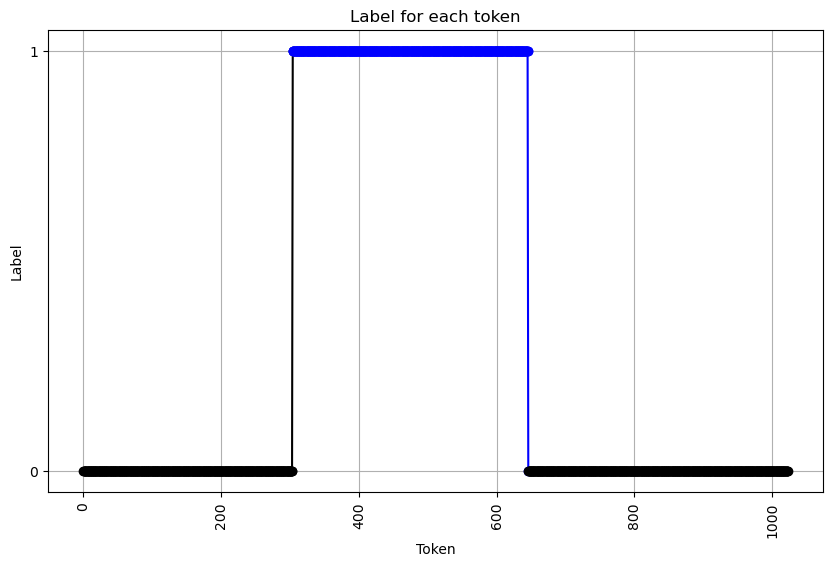

(1, 1.0) K40PH129C1_cds_56


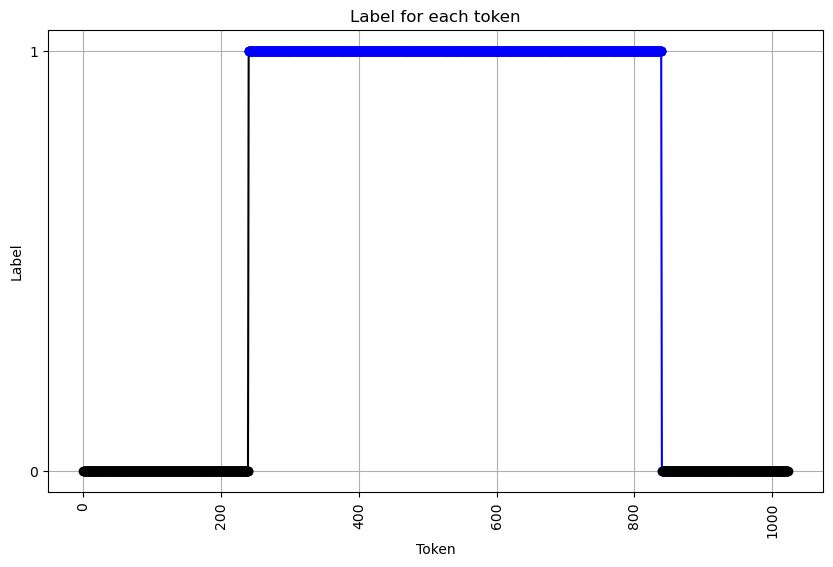

(1, 1.0) K41P2_cds_11


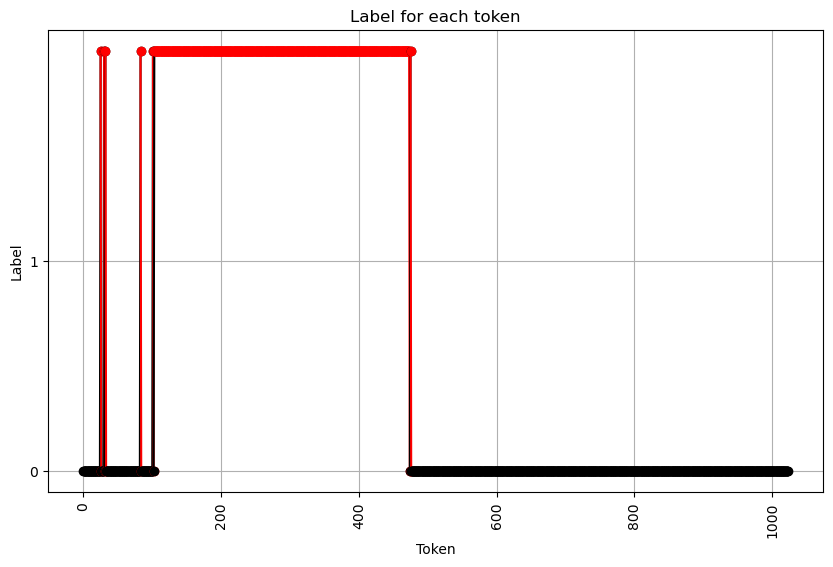

(1, 1.0) K43PH164C1_cds_40


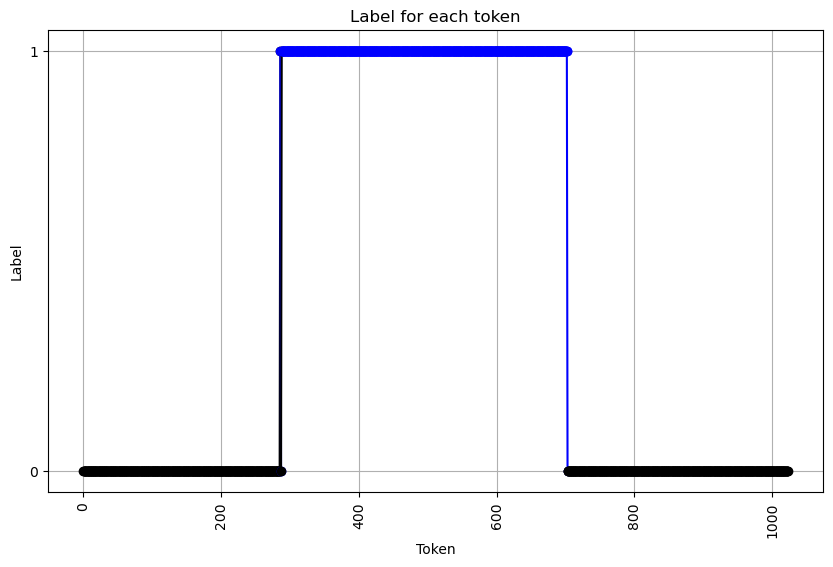

(1, 1.0) K43PH164C1_cds_41


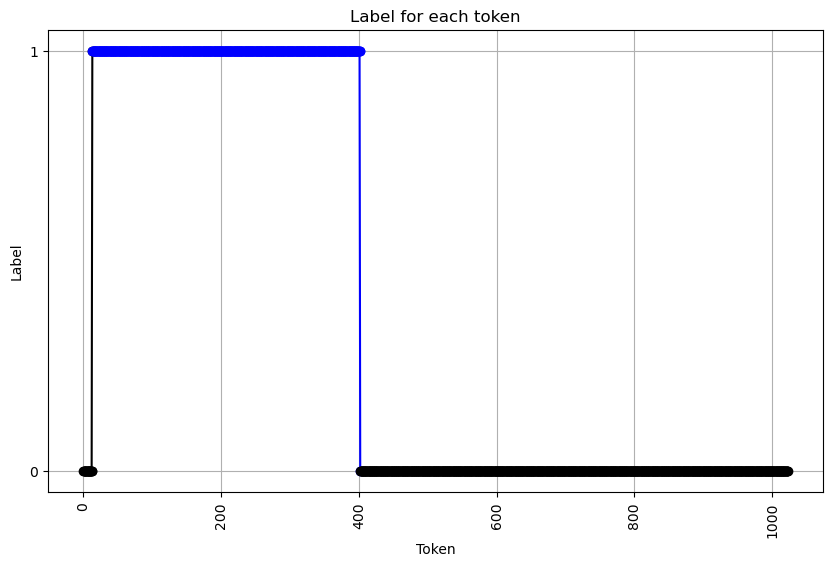

(1, 1.0) K44PH129C1_cds_9


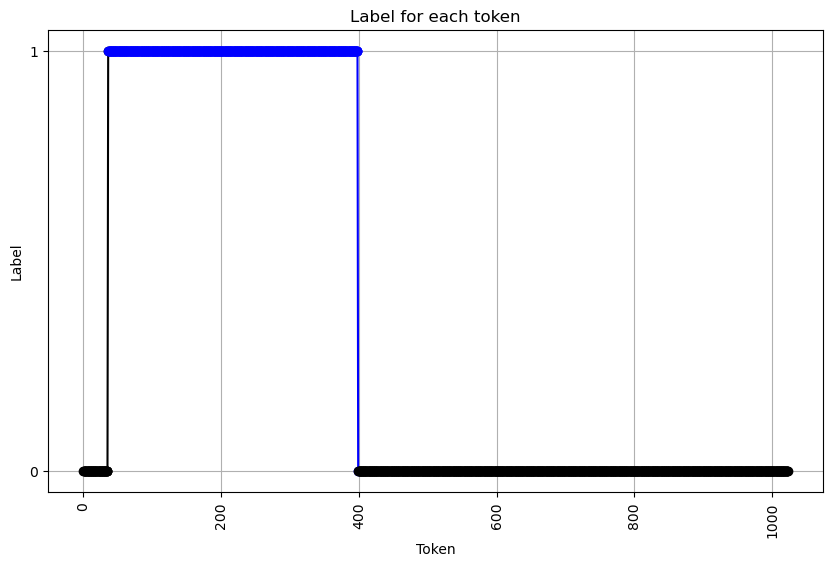

(1, 1.0) K44PH129C1_cds_10


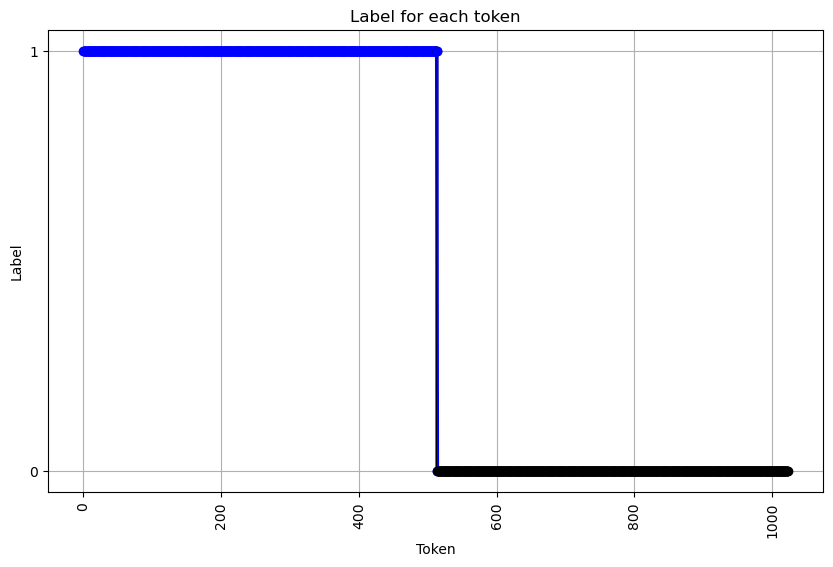

(1, 1.0) K45PH128C2_cds_237


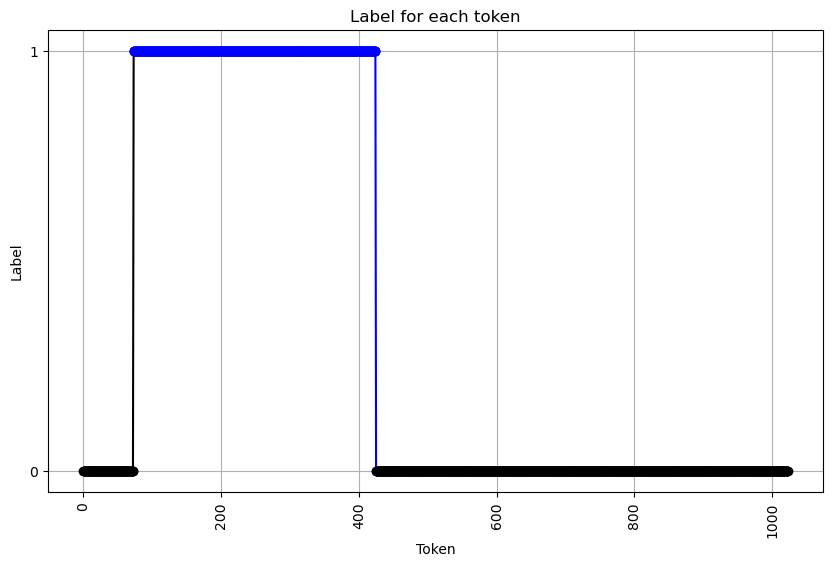

(1, 1.0) K45PH128C2_cds_239


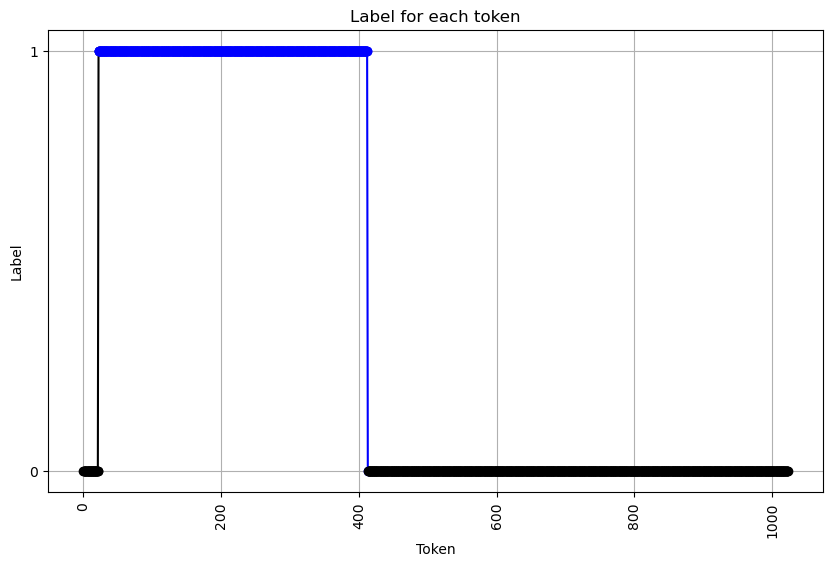

(1, 1.0) K46PH129_cds_24


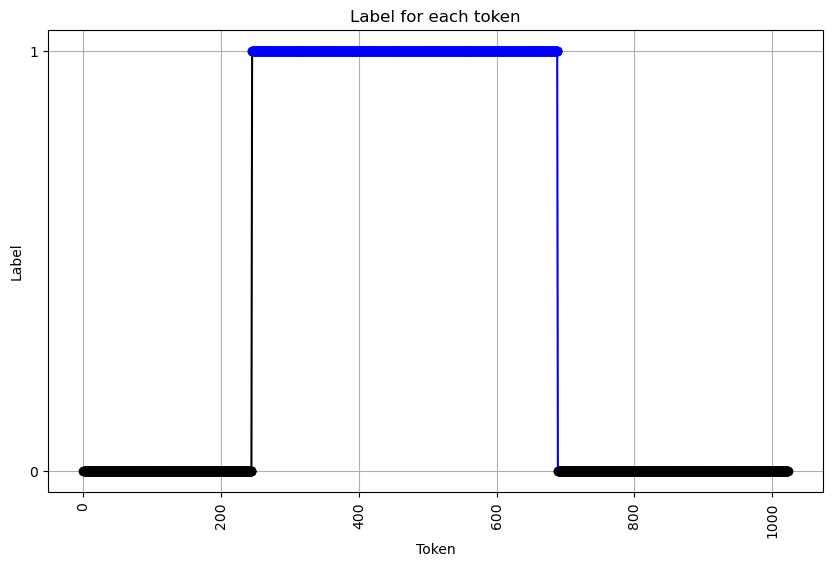

(1, 1.0) K48PH164C1_cds_49


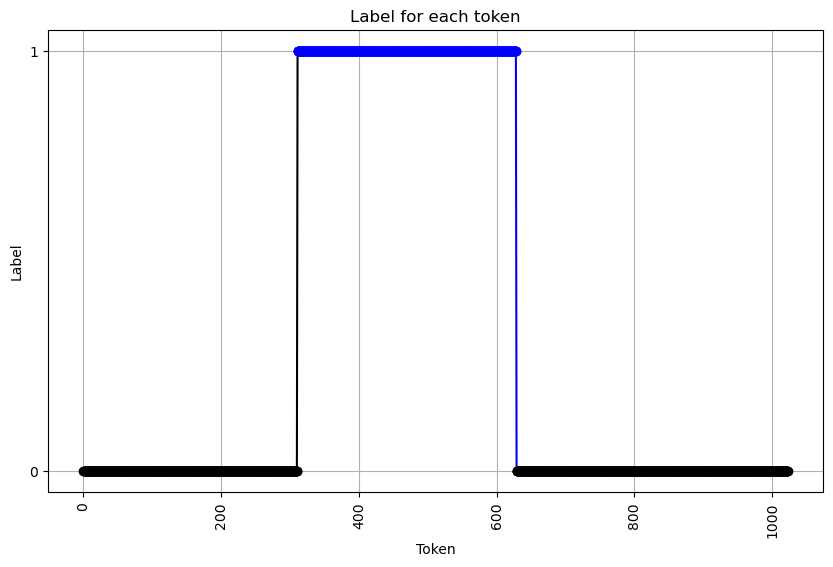

(1, 1.0) K4PH164_cds_22


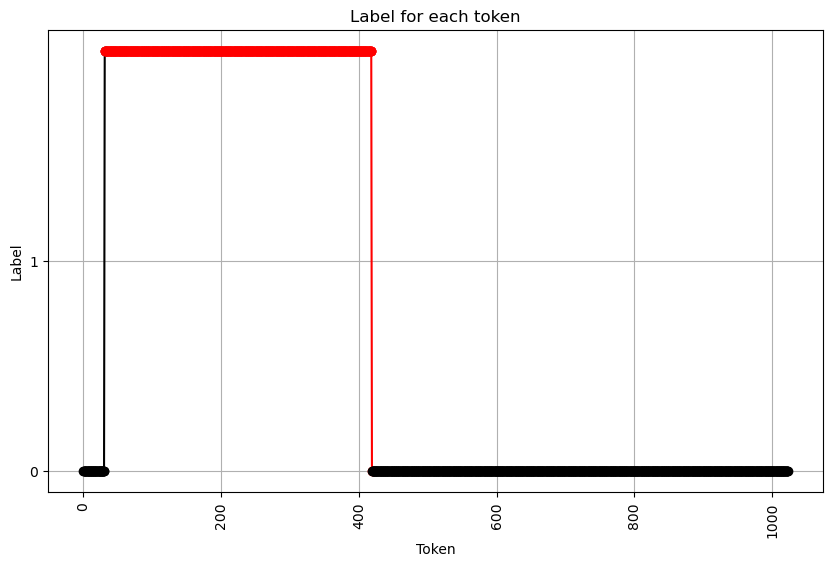

(1, 1.0) K51PH129C1_cds_9


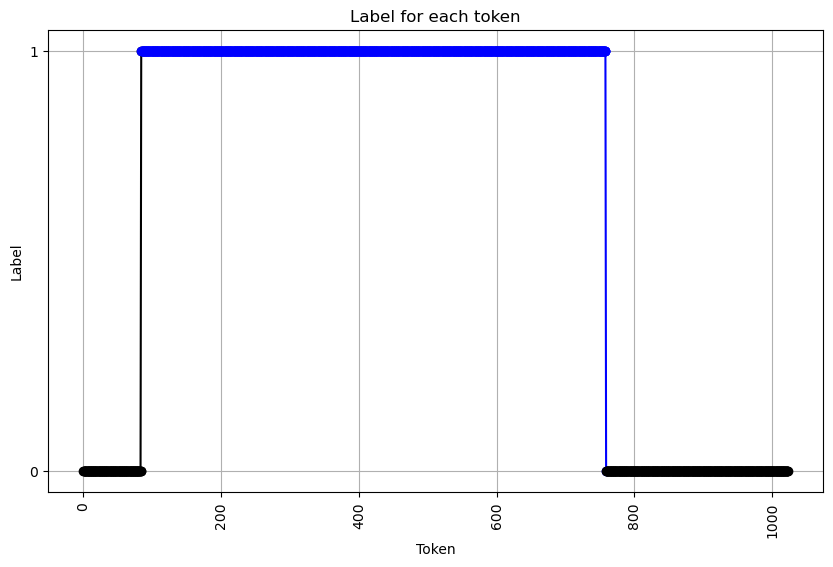

(1, 1.0) K53PH164C2_cds_24


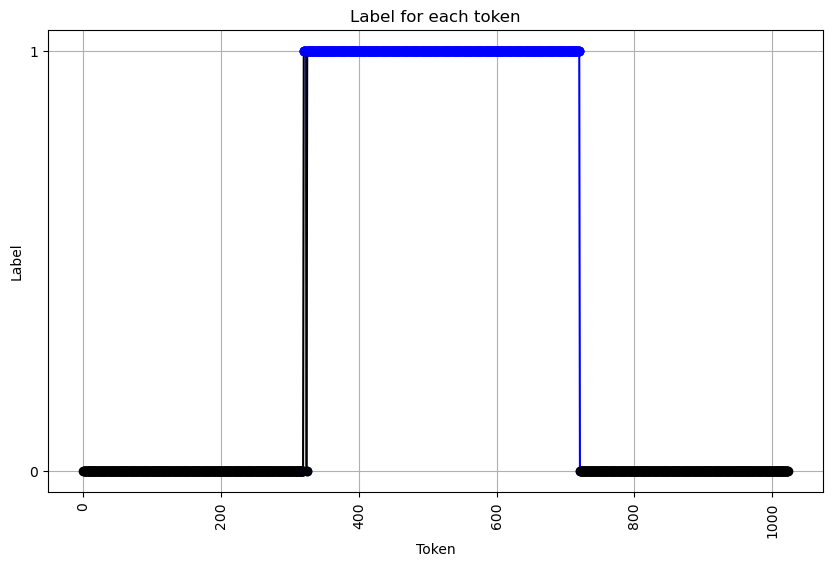

(1, 1.0) K54lambda1_1_1_cds_238


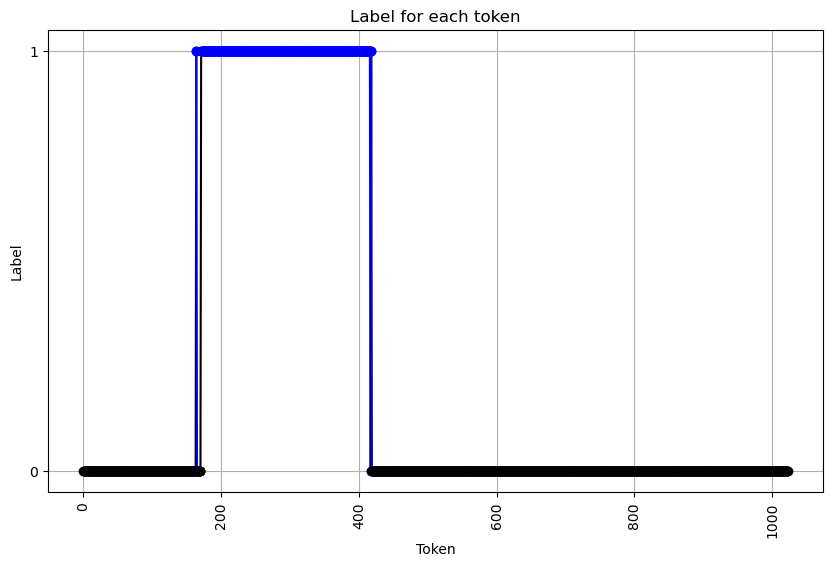

(1, 1.0) K54lambda2_cds_23


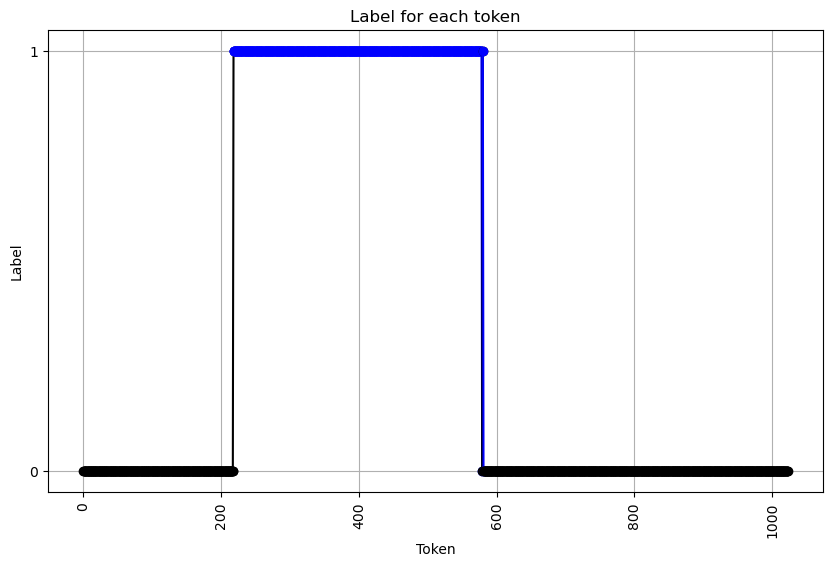

(1, 1.0) K56PH164C1_cds_48


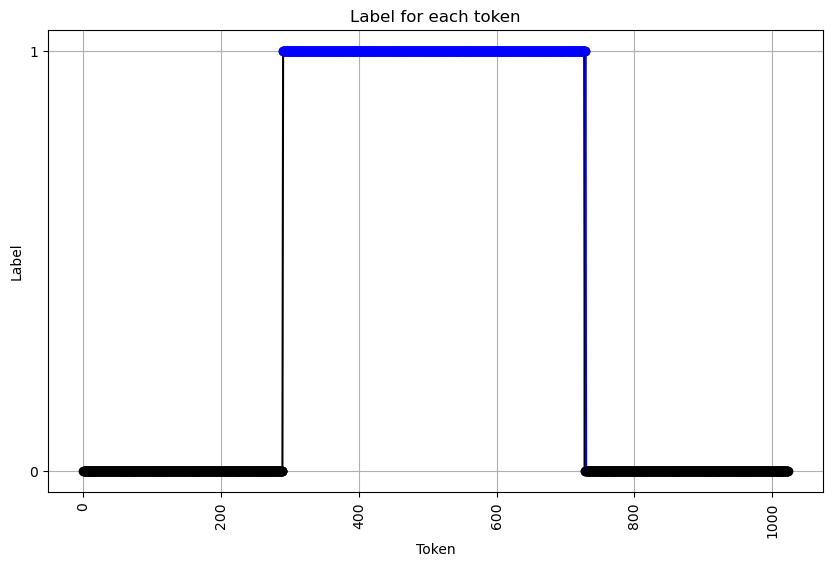

(1, 1.0) K56PH164C1_cds_49


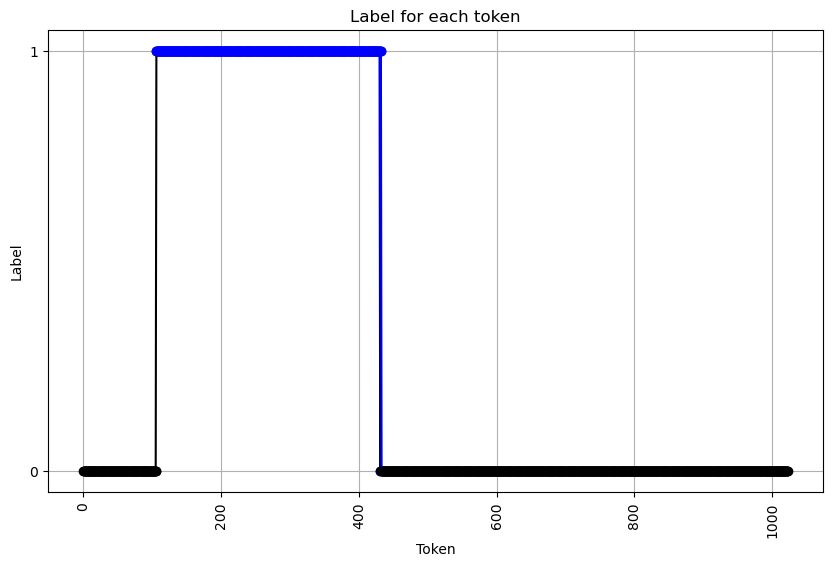

(1, 1.0) K57lambda1_2_cds_92


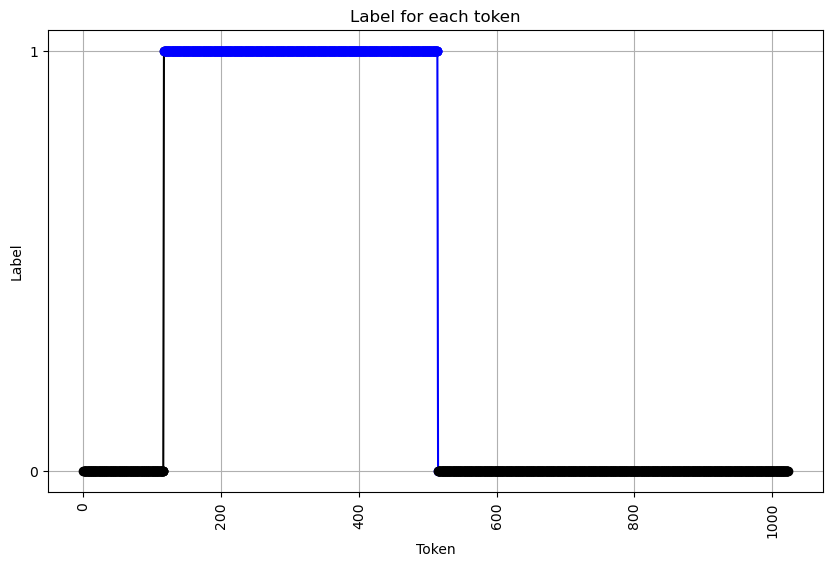

(1, 1.0) K57lambda1_2_cds_93


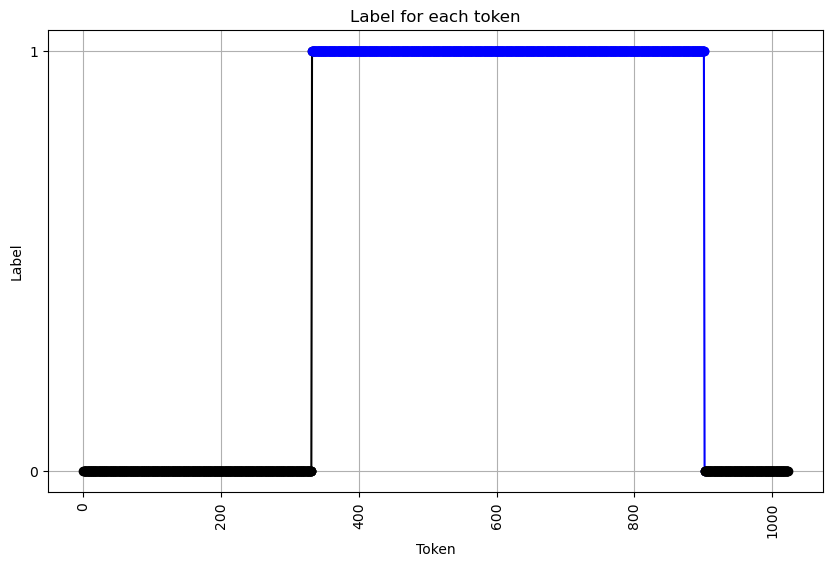

(1, 1.0) K58PH129C2_cds_47


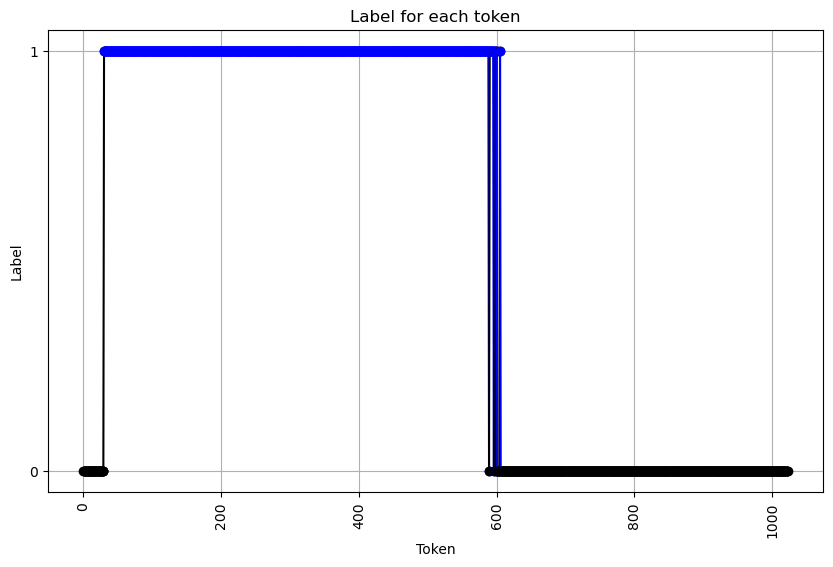

(1, 1.0) K5lambda5_cds_196


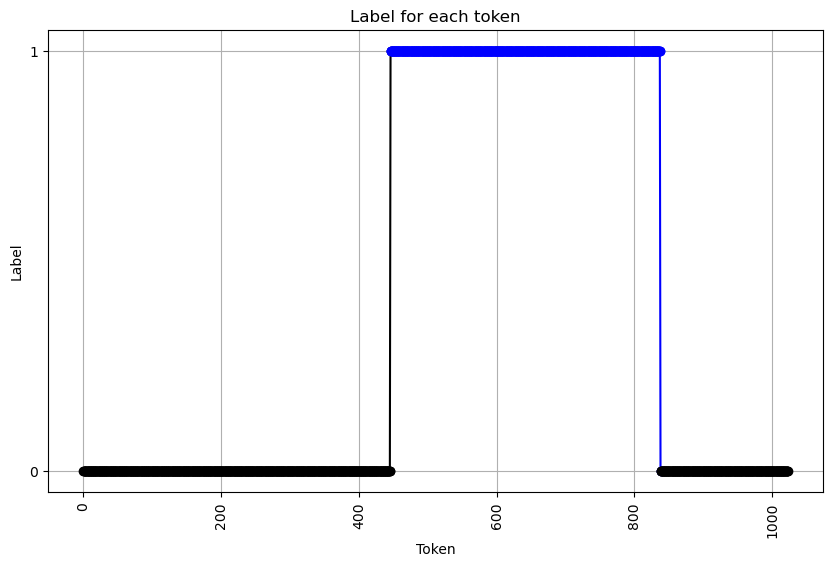

(1, 1.0) K5lambda5_cds_198


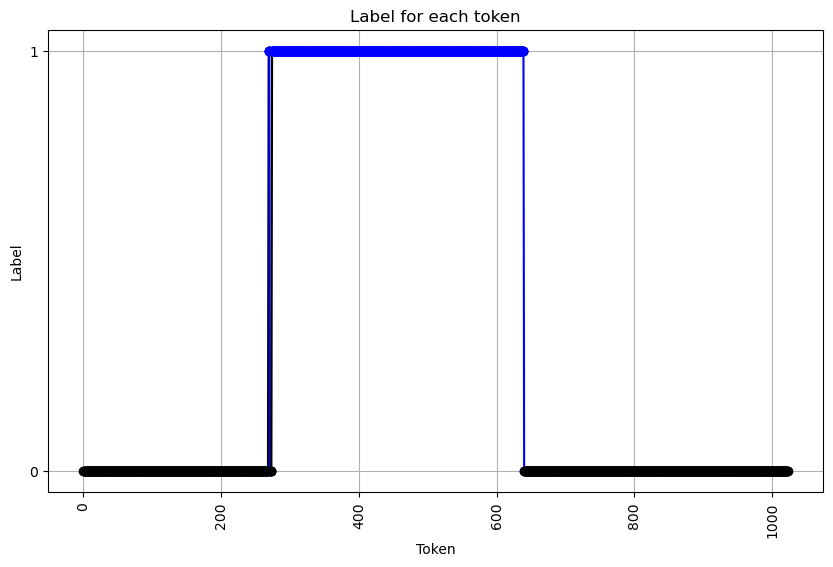

(1, 1.0) K5lambda5_cds_199


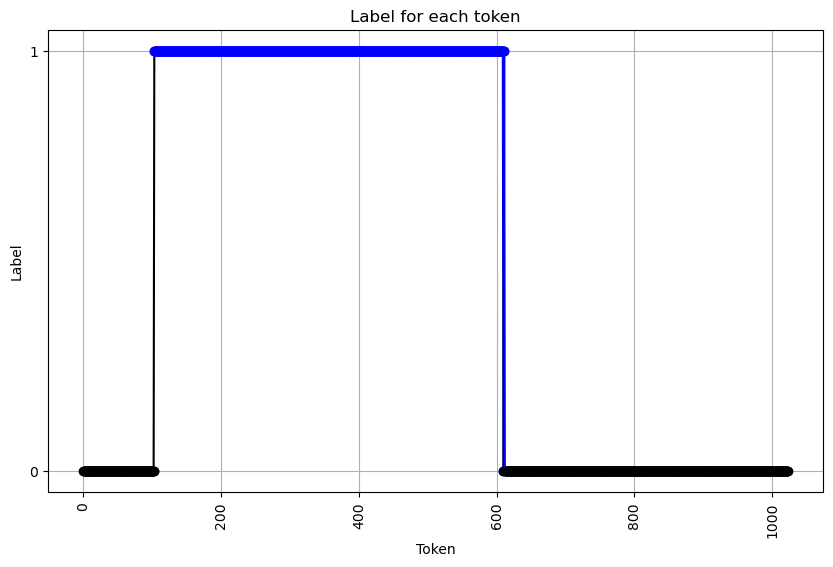

(1, 1.0) K5lambda5_cds_200


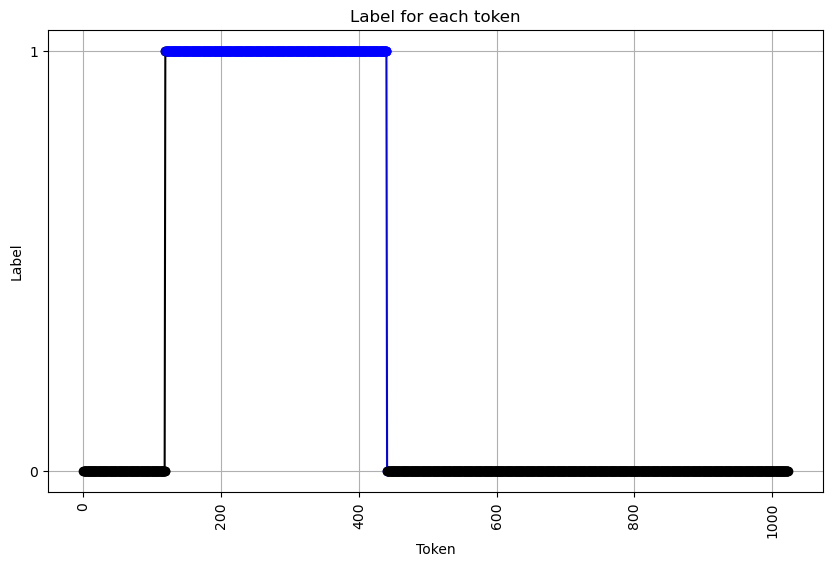

(1, 1.0) K60PH164C1_cds_94


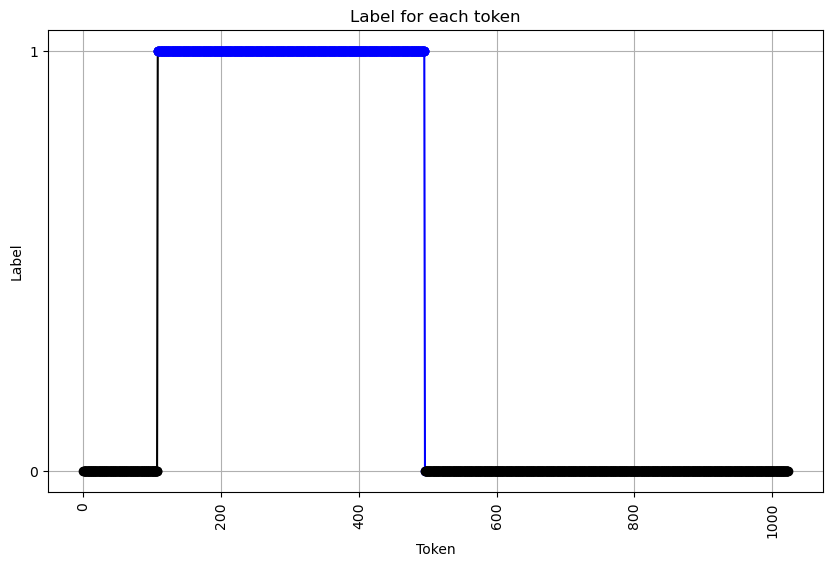

(1, 1.0) K60PH164C1_cds_96


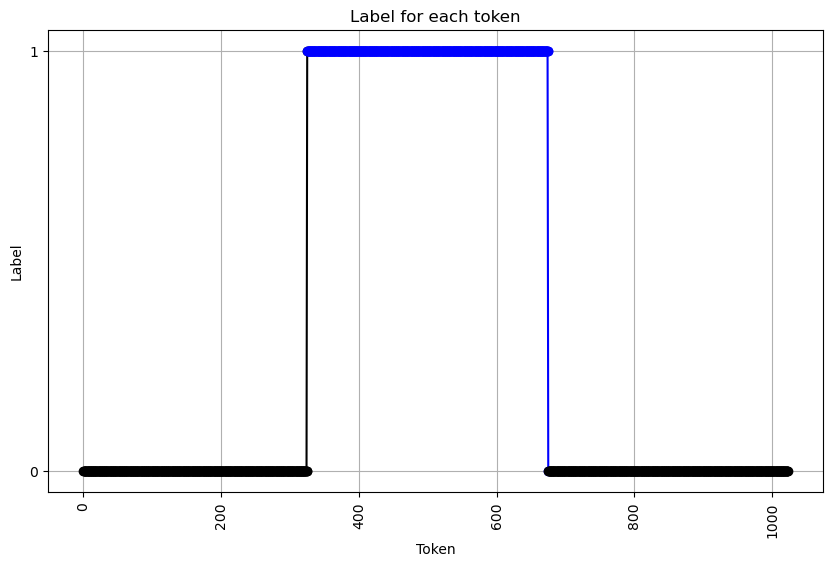

(1, 1.0) K61PH164C1_cds_9


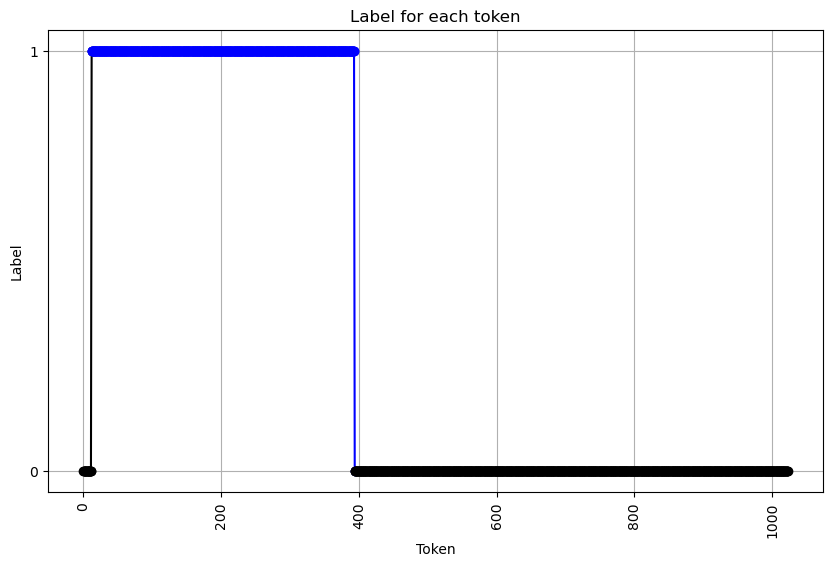

(1, 1.0) K61PH164C1_cds_10


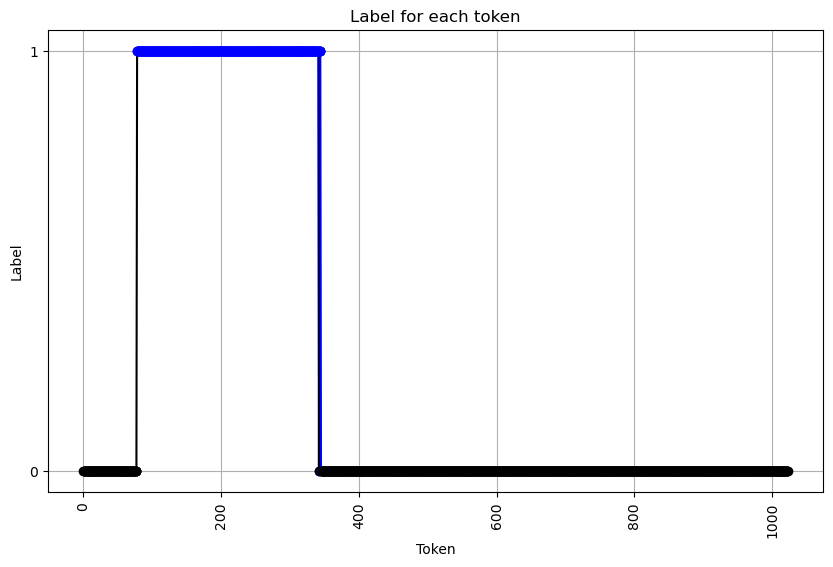

(1, 1.0) K63PH128_cds_22


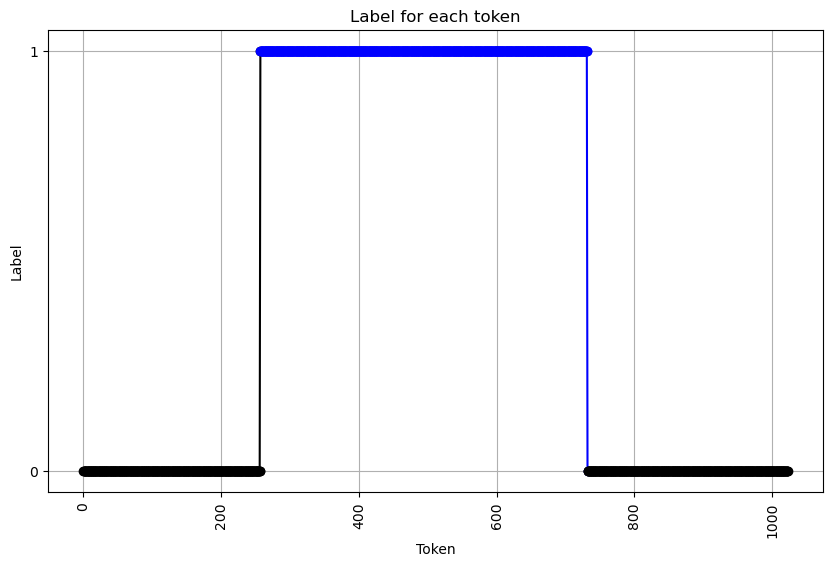

(1, 1.0) K64PH164C4_cds_24


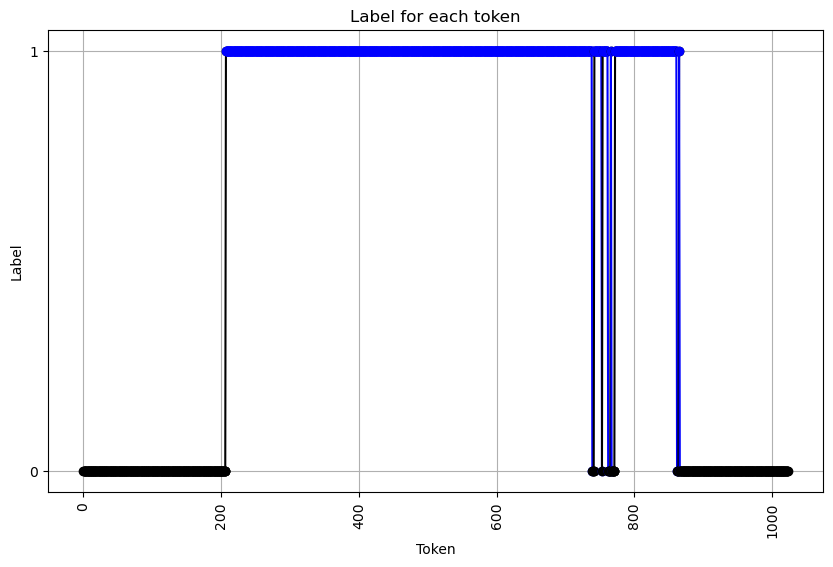

(1, 1.0) K65PH164_cds_12


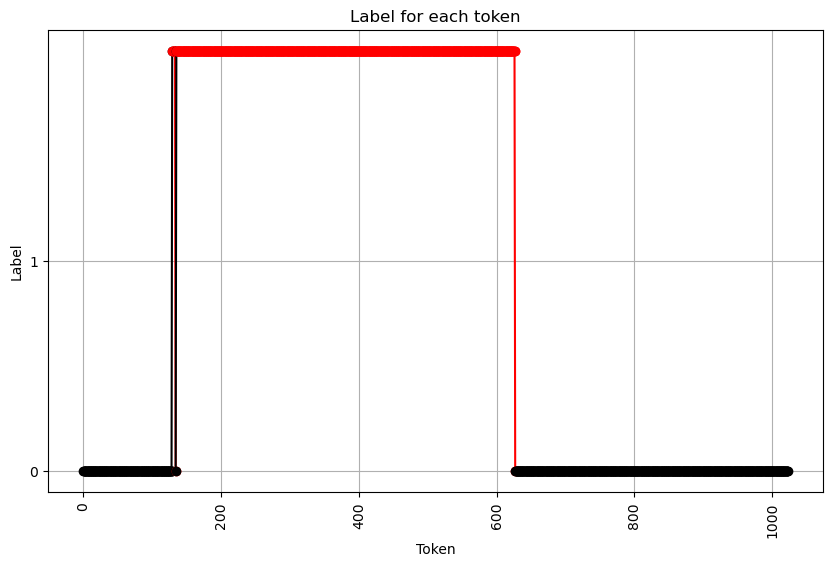

(1, 1.0) K66PH128C1_cds_59


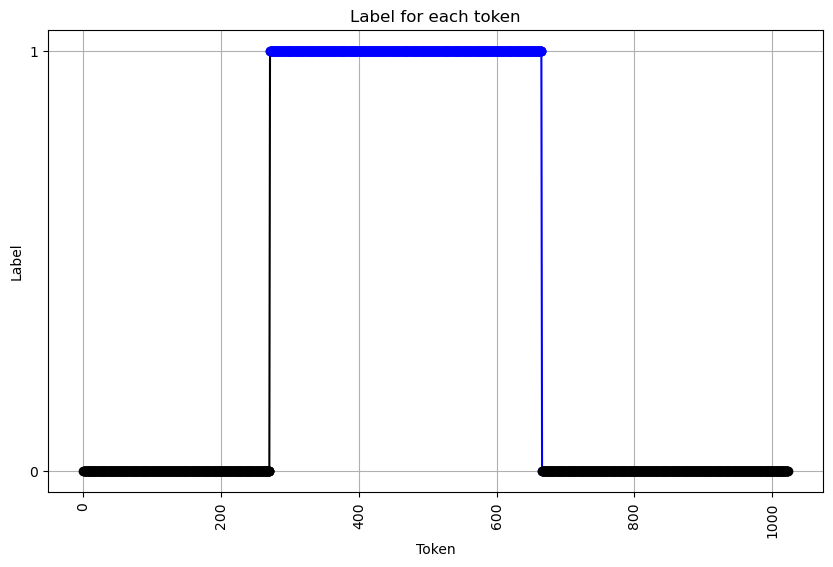

(1, 1.0) K6PH25C3_cds_23


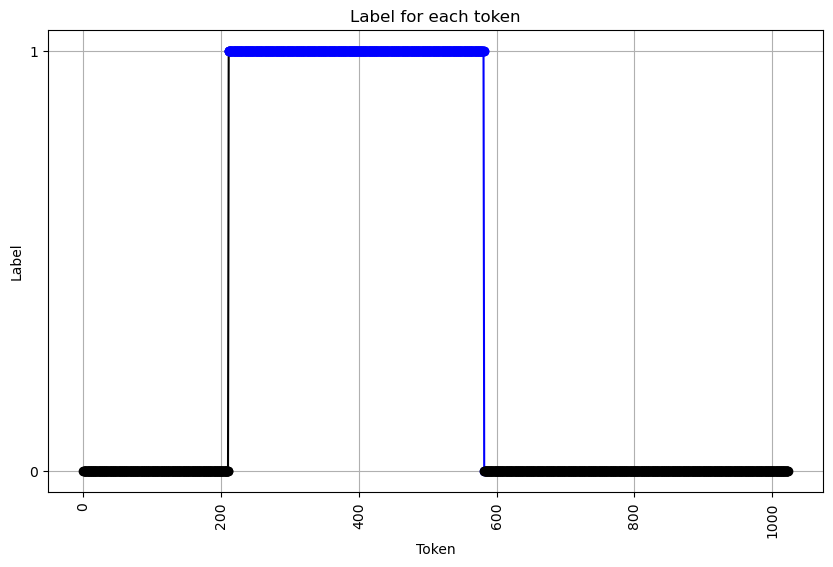

(1, 1.0) K71PH129C1_cds_55


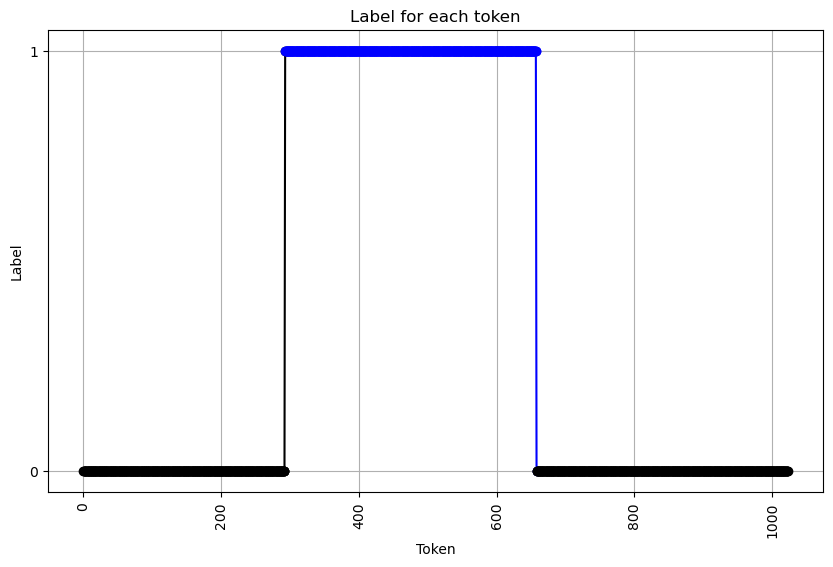

(1, 1.0) K74PH129C2_cds_51


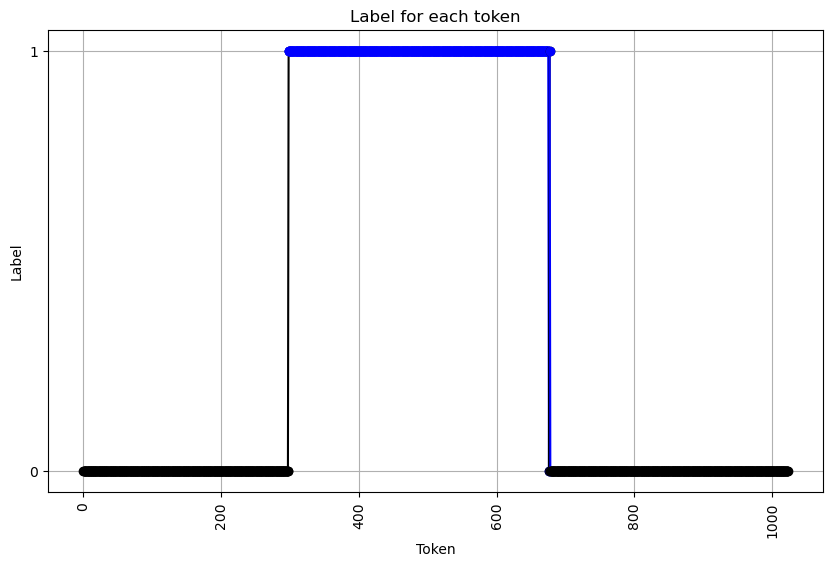

(1, 1.0) K74PH129C2_cds_52


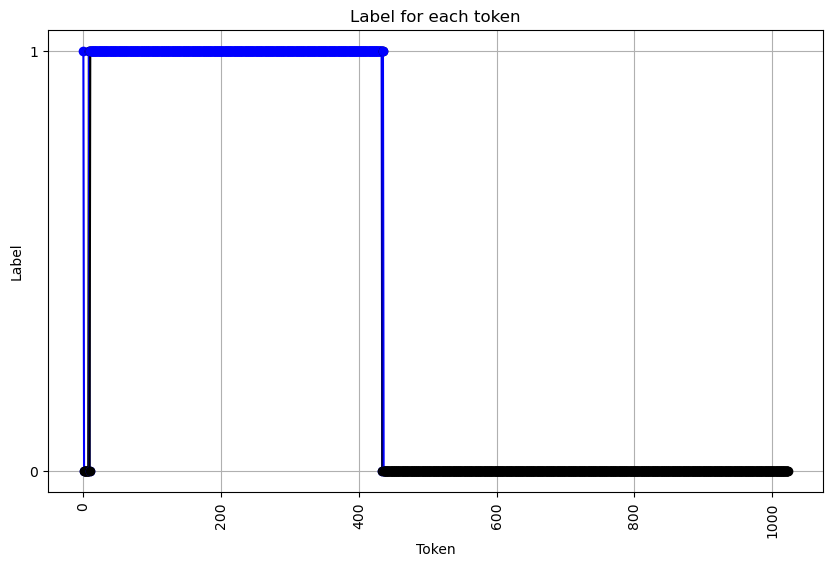

(1, 1.0) K80PH1317a_cds_52


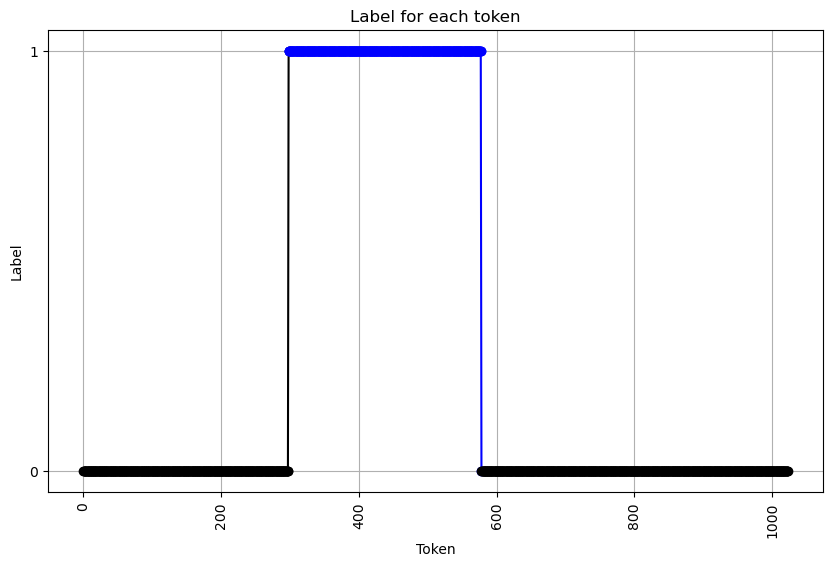

(1, 0.9999964237213135) K80PH1317a_cds_53


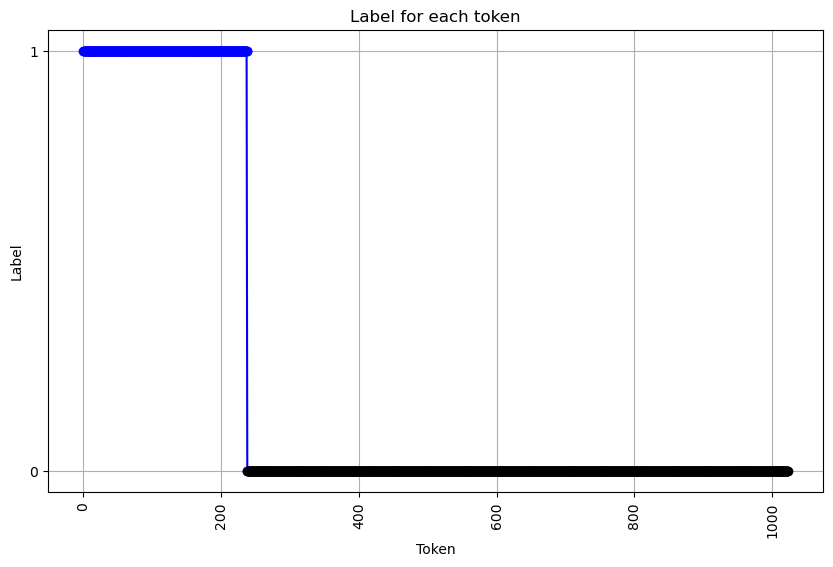

(1, 1.0) K80PH1317a_cds_54


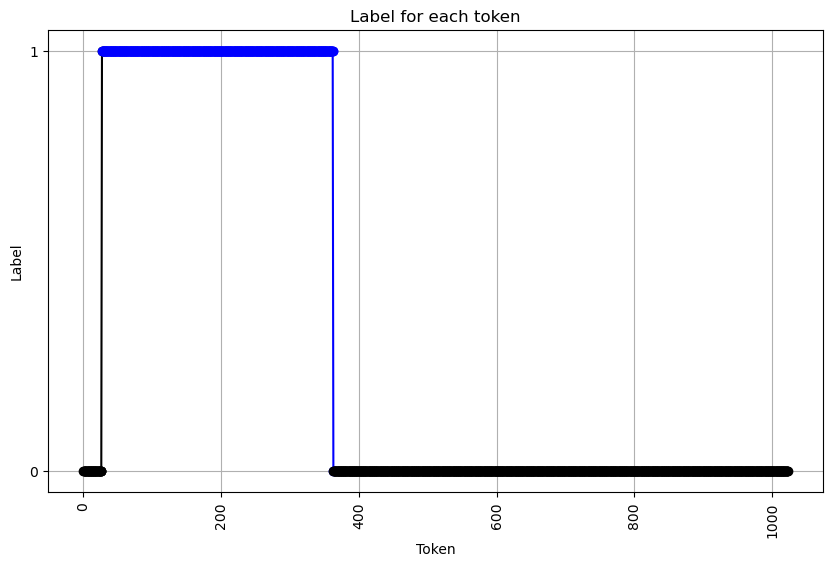

(1, 1.0) K80PH1317b_cds_52


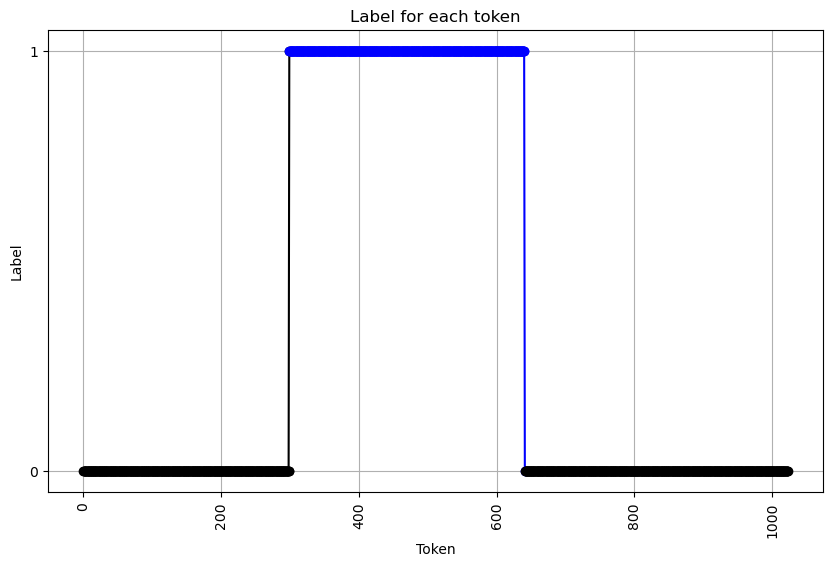

(0, 0.9221071600914001) K80PH1317b_cds_53


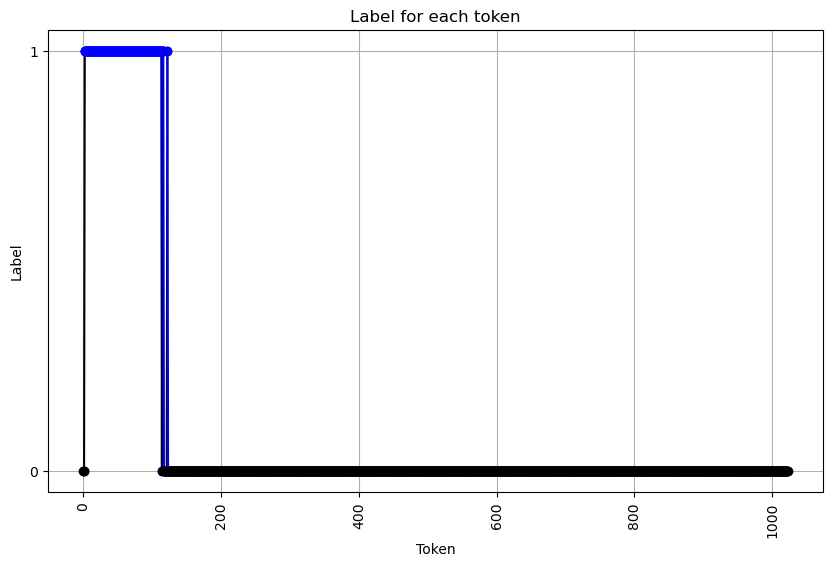

(1, 1.0) K80PH1317b_cds_54


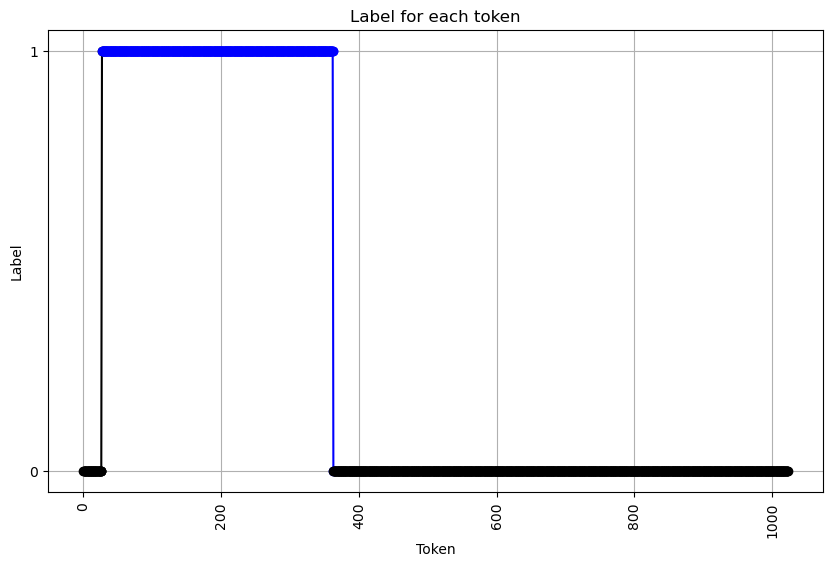

(1, 1.0) K82P1_cds_45


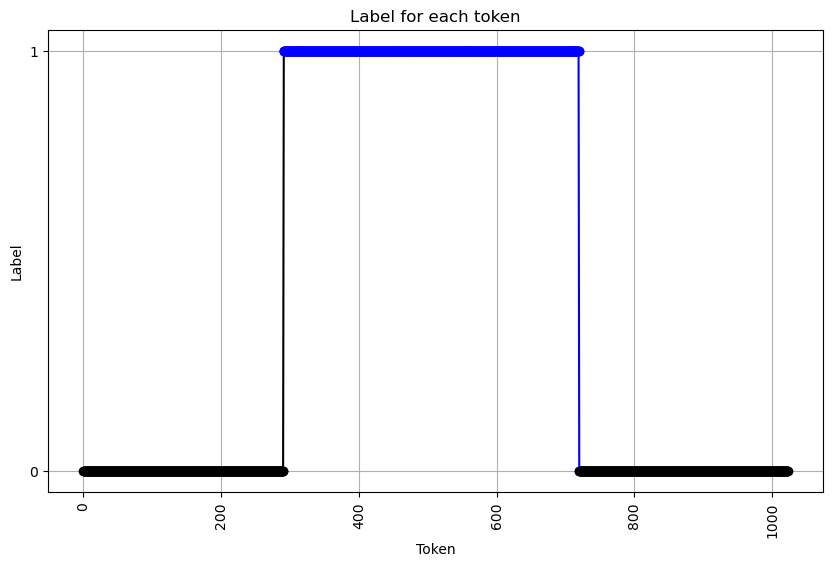

(1, 1.0) K82P1_cds_46


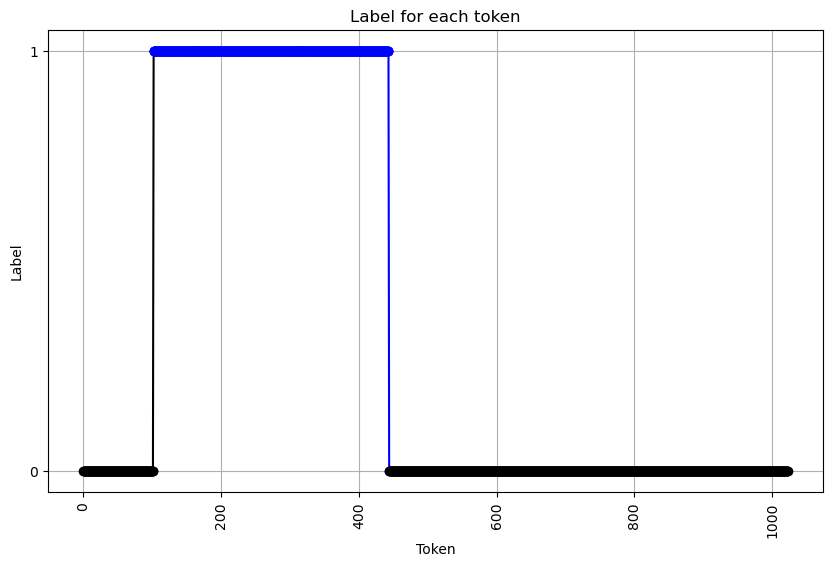

(1, 1.0) K8PH128_cds_46


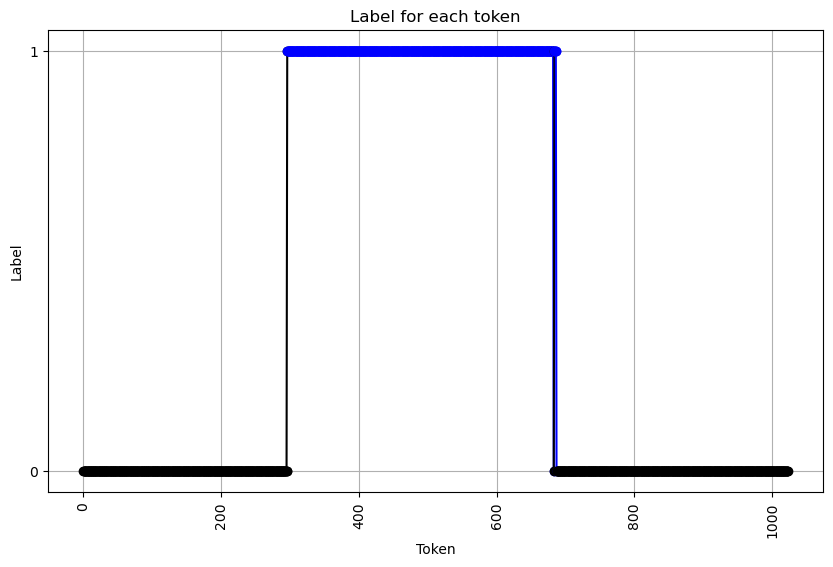

In [8]:
from Bio import SeqIO
import os

path_fasta_1 = f"{path_work}/DetectedDpo.77_phages.multi.fasta"
path_fasta_2 = f"{path_work}/MissedDpos.77_phages.multi.fasta"
paths_fasta = [path_fasta_1 , path_fasta_2]

for path_fasta in paths_fasta :
    name = path_fasta.split("/")[-1].split(".fasta")[0]
    with open(f"{path_work}/{name}.T30_predictions.out" , "w") as outfile :
        fastas = SeqIO.parse(path_fasta , "fasta")
        for record in fastas :
            prediction, sequence_outputs = predict_sequence(model_classifier, str(record.seq) , record.description)
            outfile.write(f"{record.id}\t{prediction}\t{str(sequence_outputs)}\n")

In [ ]:
#!/bin/bash
#BATCH --job-name=T30_77_pred
#SBATCH --qos=short 
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=5
#SBATCH --mem=50gb 
#SBATCH --time=1-00:00:00 
#SBATCH --output=T30_77_pred%j.log 

source /storage/apps/ANACONDA/anaconda3/etc/profile.d/conda.sh
conda activate embeddings

python /home/conchae/PhageDepo_pdb/script_files/T30_3L.predictions.77.py


***
### Pires 2016 predictions 

In [ ]:
rsync -avzhe ssh \
/media/concha-eloko/Linux/PhageDEPOdetection/Benchmarking \
conchae@garnatxa.srv.cpd:/home/conchae/PhageDepo_pdb


In [ ]:
path_out = "/home/conchae/PhageDepo_pdb/Benchmarking"
path_work = "/home/conchae/PhageDepo_pdb"

prediction_results = {}
for fasta_file in tqdm(os.listdir(path_out)) :
    fastas = SeqIO.parse(f"{path_out}/{fasta_file}" , "fasta")
    tmp_results = []
    for record in fastas :
        prediction, sequence_outputs = predict_sequence(model_classifier, str(record.seq))
        if prediction[0] == 1 :
            a = (prediction , record.id)
            tmp_results.append(a)
        else :
            pass
    prediction_results[fasta_file] = tmp_results
        
with open(f"{path_work}/T30_3L.predictions.Pires.json" , "w") as outfile : 
    json.dump(prediction_results , outfile)

In [ ]:
#!/bin/bash
#BATCH --job-name=T30_Pires_pred
#SBATCH --qos=short 
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=5
#SBATCH --mem=50gb 
#SBATCH --time=1-00:00:00 
#SBATCH --output=T30_Pires_pred%j.log 

source /storage/apps/ANACONDA/anaconda3/etc/profile.d/conda.sh
conda activate embeddings

python /home/conchae/PhageDepo_pdb/script_files/T30_3L.predictions.Pires.py